### Import Libraries

In [1]:
import os
import librosa
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import IPython
from IPython.display import display
import torch.nn as nn
import torchaudio
import torch
import torchvision.models as models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
import pickle
import warnings

warnings.filterwarnings("ignore")

### Module reloading

In [245]:
import importlib
from dl import train_test_split as tts, datasets, train, prediction_plotting
from dl.models import audio_features_cnn, audio_features_nn, melgram_cnn

importlib.reload(tts)
importlib.reload(datasets)
importlib.reload(train)
importlib.reload(prediction_plotting)

importlib.reload(audio_features_cnn)
importlib.reload(audio_features_nn)
importlib.reload(melgram_cnn)

<module 'dl.models.melgram_cnn' from 'c:\\Users\\AnnaKoutougera\\Desktop\\DeepFake-Voice-Recognition\\dl\\models\\melgram_cnn.py'>

### Constants

In [3]:
# TODO: Ask if choice of target_sample_rate, segment_length and batch size is okay
audio_dir = "./AUDIO/"
demostration_dir = "./DEMONSTRATION/"
segment_length = 3  # 3 to 5 seconds is a good range for speech processing
target_sample_rate = 16000  # 16000 Hz is a standard sample rate for speech processing. Another common value is 22050 Hz. We can also try 8000
noise_threshold = 0.005  # Threshold for detecting noise NOT NEEDED
clean_audio_dir = "./CLEAN_AUDIO/"  # Directory to save cleaned audio files
output_file_dataset = "./classic_dataset.csv"  # File to save the dataset
output_file_dataset_augmented = (
    "./classic_dataset_augmented.csv"  # File to save the augmented dataset
)
output_file_images = "./annotations_images.csv"  # File to save the images annotations
output_file_images_augmented = "./annotations_images_augmented.csv"  # File to save the augmented images annotations
batch_size = 32
testing_samples = ["ryan", "margot"]

### Read necessary files

In [57]:
image_annotations = pd.read_csv(output_file_images)
classic_df = pd.read_csv(output_file_dataset)
img_dir = "./mel_spectograms/"
saved_models_dir = "./saved_models/"
# make sure the directory exists
os.makedirs(saved_models_dir, exist_ok=True)
input_dim = 26  # 26 features in x
output_dim = 1  # 1 output

In [60]:
classic_df

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,original_sample,LABEL
0,0.406384,2.330633e-06,1726.659103,1313.571519,2691.655585,0.166597,-1100.7047,24.245398,-4.094656,-11.856869,...,-0.645655,-1.132683,-2.797139,-3.261496,-0.838549,0.040131,-0.060138,-1.380203,biden-to-linus,FAKE
1,0.488609,1.630667e-06,1494.082478,1153.538601,2407.413564,0.133025,-1096.9451,24.470573,-14.613540,-24.321949,...,-4.825898,-5.560425,-2.493666,0.818739,1.947798,2.038546,0.929982,-0.998090,biden-to-linus,FAKE
2,0.362642,3.494457e-06,1782.153328,1487.245881,3030.917553,0.133561,-1091.5063,32.406384,6.421868,0.284660,...,-2.619975,-1.499475,-1.358122,-2.547379,-2.780402,-4.007704,-1.956772,-2.554486,biden-to-linus,FAKE
3,0.504108,1.450140e-06,1674.292000,1243.940908,2822.639628,0.154214,-1096.3278,22.428860,-19.769522,-29.950434,...,-6.615263,-6.136813,-0.366889,2.285026,2.371739,1.385045,0.033286,1.461742,biden-to-linus,FAKE
4,0.350327,2.722246e-06,1806.171266,1466.977633,3179.770612,0.151310,-1098.4668,25.184458,2.385725,-2.529006,...,-4.927869,-4.255583,-3.070756,-1.945262,-1.668957,-3.041227,-2.284557,-1.515251,biden-to-linus,FAKE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9971,0.316170,1.284757e-06,1682.845217,1652.609098,3072.639628,0.111993,-1114.6527,15.194299,4.524409,3.563511,...,-0.320019,-0.010580,-1.126601,-1.196117,-0.631510,-0.997464,-1.297959,-0.855158,trump-original,REAL
9972,0.390607,7.107834e-07,1616.014539,1708.714104,3233.460771,0.111874,-1121.9220,10.930627,6.196433,2.819153,...,-0.427091,-0.014760,-0.732595,-1.226603,-0.793108,-0.386619,-0.622035,-0.927777,trump-original,REAL
9973,0.365970,1.233685e-06,2452.892084,1866.356939,4280.751330,0.226599,-1118.0184,13.119451,9.031300,4.715108,...,-1.801935,-0.429014,-0.371208,-0.587302,-0.158402,-0.792658,-0.824357,-0.328380,trump-original,REAL
9974,0.341479,1.393258e-06,1980.140163,1735.292494,3500.664894,0.148453,-1112.7692,16.963621,4.313049,2.521054,...,-0.666117,0.704803,-0.250046,-1.549501,-1.564756,-1.418983,-1.488376,-1.166654,trump-original,REAL


### Set device

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

Using device cuda


### Modelling data

Images

In [32]:
image_annotations_train, image_annotations_val, image_annotations_test = (
    tts.train_test_split_dataset(
        image_annotations,
        testing_samples=testing_samples,
        val_size=0.1,
        random_state=42,
        tag="image",
    )
)
# Define the label mapping
label_mapping = {"REAL": 1, "FAKE": 0}

# Create the target transform using the label mapping
target_transform = lambda x: label_mapping[x]

# Create an instance of the CustomImageDataset
training_image_data = datasets.CustomPickleDataset(
    image_annotations_train, img_dir, target_transform, device=device
)
validation_image_data = datasets.CustomPickleDataset(
    image_annotations_val, img_dir, target_transform, device=device
)
testing_image_data = datasets.CustomPickleDataset(
    image_annotations_test, img_dir, target_transform, device=device
)

# Create DataLoaders for the data
train_image_dataloader = DataLoader(
    training_image_data, batch_size=batch_size, shuffle=True
)
val_image_dataloader = DataLoader(
    validation_image_data, batch_size=batch_size, shuffle=True
)
test_image_dataloader = DataLoader(
    testing_image_data, batch_size=batch_size, shuffle=True
)

Classic Dataset

In [13]:
classic_df_train, classic_df_val, classic_df_test = tts.train_test_split_dataset(
    classic_df,
    testing_samples=testing_samples,
    val_size=0.1,
    random_state=42,
    tag="tabular",
)


# Define the label mapping
label_mapping = {"REAL": 1, "FAKE": 0}
# Create the target transform using the label mapping
target_transform = lambda x: label_mapping[x]


cnn_training_data = datasets.CustomClassicDataset(
    classic_df_train, target_transform=target_transform, device=device, tag="cnn"
)
cnn_validation_data = datasets.CustomClassicDataset(
    classic_df_val, target_transform=target_transform, device=device, tag="cnn"
)
cnn_testing_data = datasets.CustomClassicDataset(
    classic_df_test, target_transform=target_transform, device=device, tag="cnn"
)


# Create DataLoaders for the data
train_cnn_dataloader = DataLoader(
    cnn_training_data, batch_size=batch_size, shuffle=True
)
val_cnn_dataloader = DataLoader(
    cnn_validation_data, batch_size=batch_size, shuffle=True
)
test_cnn_dataloader = DataLoader(cnn_testing_data, batch_size=batch_size, shuffle=True)

nn_training_data = datasets.CustomClassicDataset(
    classic_df_train, target_transform=target_transform, device=device, tag="nn"
)
nn_validation_data = datasets.CustomClassicDataset(
    classic_df_val, target_transform=target_transform, device=device, tag="nn"
)
nn_testing_data = datasets.CustomClassicDataset(
    classic_df_test, target_transform=target_transform, device=device, tag="nn"
)


# Create DataLoaders for the data
train_nn_dataloader = DataLoader(nn_training_data, batch_size=batch_size, shuffle=True)
val_nn_dataloader = DataLoader(nn_validation_data, batch_size=batch_size, shuffle=True)
test_nn_dataloader = DataLoader(nn_testing_data, batch_size=batch_size, shuffle=True)

## Models

### With Audio Features

#### NN

In [71]:
# Define model
model = audio_features_nn.AudioFeatureNN1(input_dim, output_dim).to(device)
summary(model, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 26]             702
              ReLU-2                [-1, 1, 26]               0
            Linear-3                [-1, 1, 26]             702
              ReLU-4                [-1, 1, 26]               0
            Linear-5                [-1, 1, 26]             702
              ReLU-6                [-1, 1, 26]               0
            Linear-7                [-1, 1, 26]             702
              ReLU-8                [-1, 1, 26]               0
            Linear-9                [-1, 1, 26]             702
             ReLU-10                [-1, 1, 26]               0
           Linear-11                 [-1, 1, 1]              27
          Sigmoid-12                 [-1, 1, 1]               0
Total params: 3,537
Trainable params: 3,537
Non-trainable params: 0
-----------------------------------

Epoch 1/60, Train Loss: 1.0970, Train Acc: 0.1733, Val Loss: 1.0119, Val Acc: 0.3403, Val Precision: 0.1565, Val Recall: 0.9748, Val F1: 0.2698
Model saved at epoch 1
Epoch 2/60, Train Loss: 0.9985, Train Acc: 0.4080, Val Loss: 1.0024, Val Acc: 0.5179, Val Precision: 0.1875, Val Recall: 0.8571, Val F1: 0.3077
Model saved at epoch 2
Epoch 3/60, Train Loss: 0.9936, Train Acc: 0.4558, Val Loss: 0.9998, Val Acc: 0.5357, Val Precision: 0.1947, Val Recall: 0.8655, Val F1: 0.3179
Model saved at epoch 3
Epoch 4/60, Train Loss: 0.9832, Train Acc: 0.5155, Val Loss: 1.0010, Val Acc: 0.5767, Val Precision: 0.2090, Val Recall: 0.8571, Val F1: 0.3361
Model saved at epoch 4
Epoch 5/60, Train Loss: 0.9797, Train Acc: 0.5022, Val Loss: 0.9988, Val Acc: 0.5084, Val Precision: 0.1976, Val Recall: 0.9580, Val F1: 0.3276
Epoch 6/60, Train Loss: 0.9650, Train Acc: 0.4833, Val Loss: 0.9570, Val Acc: 0.4989, Val Precision: 0.1956, Val Recall: 0.9664, Val F1: 0.3253
Epoch 7/60, Train Loss: 0.9489, Train Acc: 0

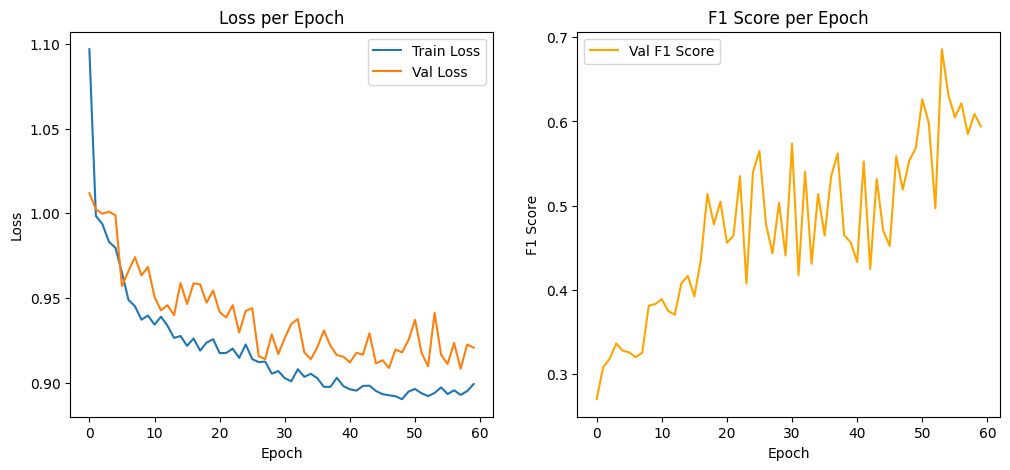

In [72]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 6.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_nn_dataloader,
    val_nn_dataloader,
    num_epochs=60,
    save_path=os.path.join(saved_models_dir, "nn1_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL   margot-to-ryan: FAKE
margot-original: REAL  margot-to-linus: FAKE
                         ryan-to-linus: FAKE
                        ryan-to-taylor: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-biden: FAKE
                        margot-to-musk: FAKE
                      margot-to-taylor: FAKE
                       margot-to-trump: FAKE
                        ryan-to-margot: FAKE
                       margot-to-obama: FAKE
                       margot-to-biden: FAKE
                         ryan-to-obama: FAKE
                         ryan-to-trump: FAKE


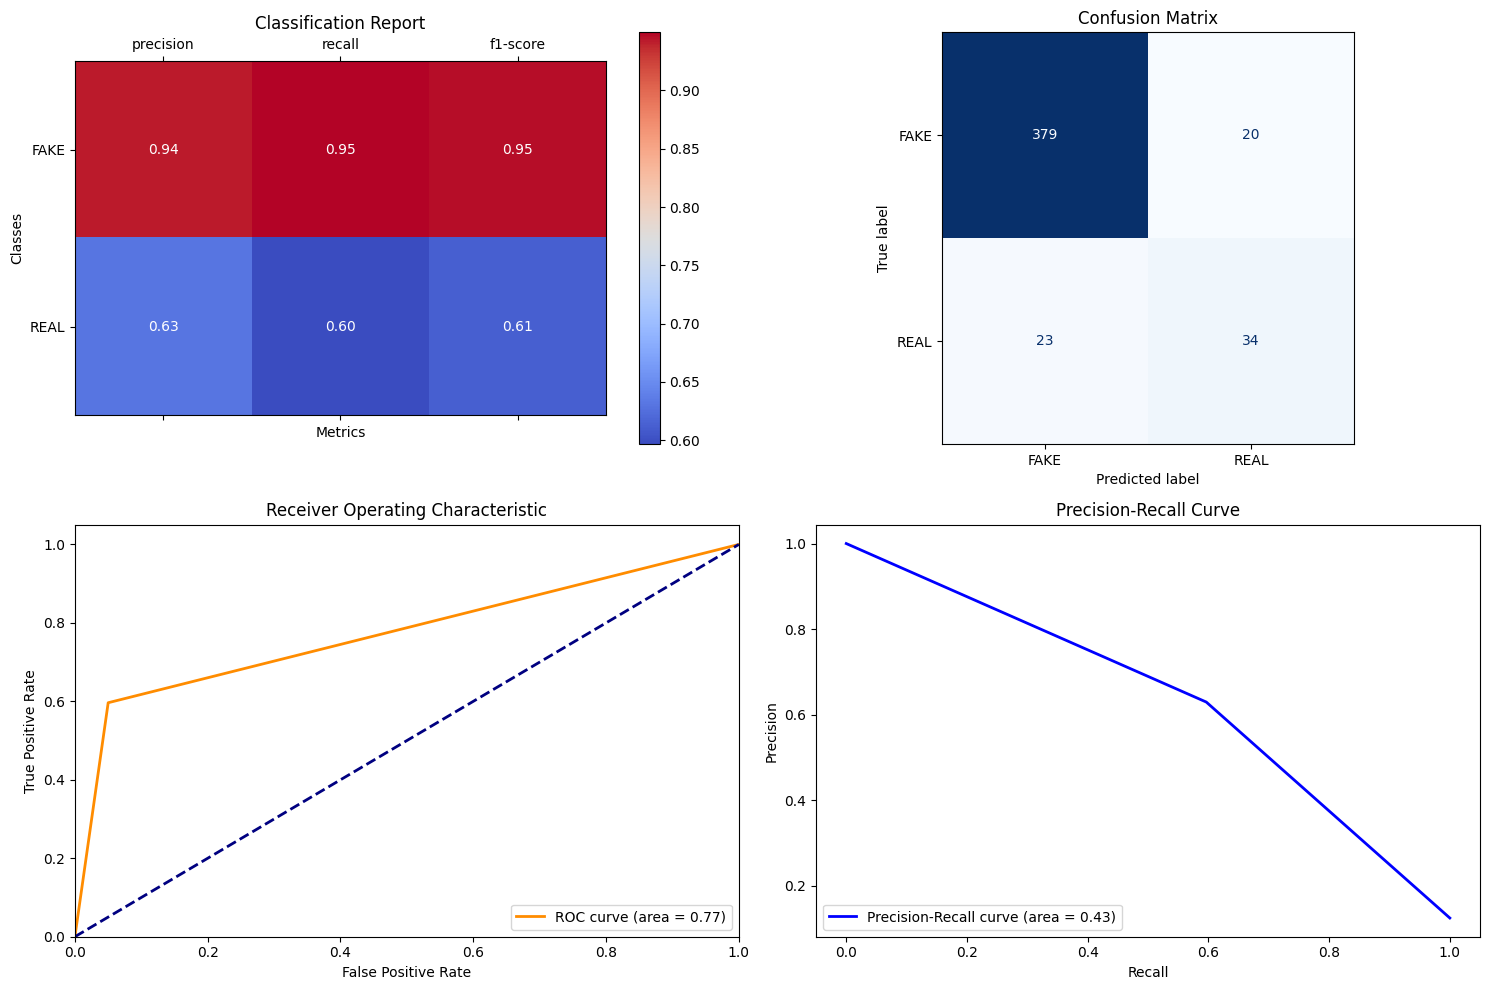

In [73]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "nn1_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_nn_dataloader, device)

In [58]:
# Define model
model = audio_features_nn.AudioFeatureNN2(input_dim, output_dim).to(device)
summary(model, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 52]           1,404
              ReLU-2                [-1, 1, 52]               0
           Dropout-3                [-1, 1, 52]               0
            Linear-4               [-1, 1, 104]           5,512
              ReLU-5               [-1, 1, 104]               0
           Dropout-6               [-1, 1, 104]               0
            Linear-7                [-1, 1, 52]           5,460
              ReLU-8                [-1, 1, 52]               0
           Dropout-9                [-1, 1, 52]               0
           Linear-10                [-1, 1, 26]           1,378
             ReLU-11                [-1, 1, 26]               0
          Dropout-12                [-1, 1, 26]               0
           Linear-13                 [-1, 1, 1]              27
          Sigmoid-14                 [-

Epoch 1/60, Train Loss: 1.1072, Train Acc: 0.1860, Val Loss: 1.0594, Val Acc: 0.3004, Val Precision: 0.1480, Val Recall: 0.9664, Val F1: 0.2567
Model saved at epoch 1
Epoch 2/60, Train Loss: 1.0301, Train Acc: 0.3568, Val Loss: 1.0341, Val Acc: 0.5242, Val Precision: 0.1776, Val Recall: 0.7731, Val F1: 0.2889
Model saved at epoch 2
Epoch 3/60, Train Loss: 1.0159, Train Acc: 0.4790, Val Loss: 0.9951, Val Acc: 0.5567, Val Precision: 0.1863, Val Recall: 0.7563, Val F1: 0.2990
Model saved at epoch 3
Epoch 4/60, Train Loss: 1.0050, Train Acc: 0.5068, Val Loss: 0.9936, Val Acc: 0.5441, Val Precision: 0.1818, Val Recall: 0.7563, Val F1: 0.2932
Epoch 5/60, Train Loss: 0.9993, Train Acc: 0.5601, Val Loss: 0.9966, Val Acc: 0.6303, Val Precision: 0.2138, Val Recall: 0.7311, Val F1: 0.3308
Model saved at epoch 5
Epoch 6/60, Train Loss: 0.9929, Train Acc: 0.6197, Val Loss: 0.9892, Val Acc: 0.6723, Val Precision: 0.2342, Val Recall: 0.7143, Val F1: 0.3527
Model saved at epoch 6
Epoch 7/60, Train Los

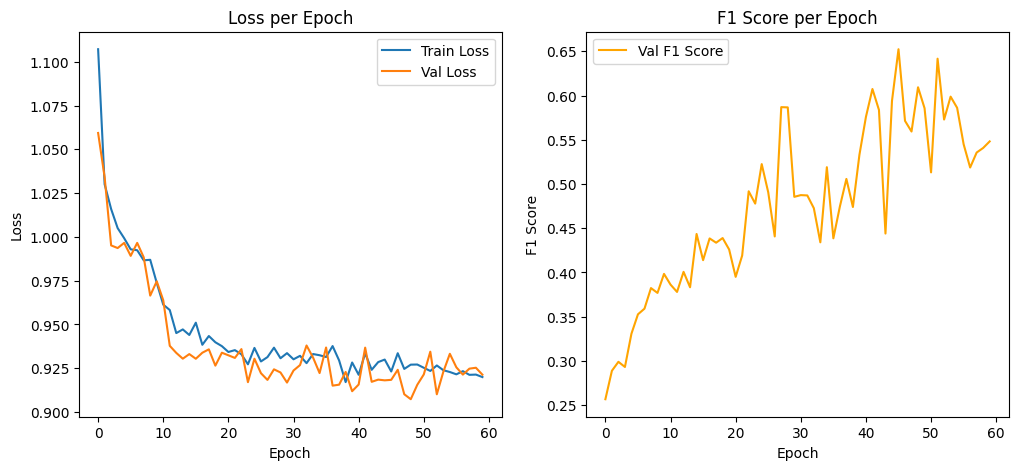

In [59]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 6.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_nn_dataloader,
    val_nn_dataloader,
    num_epochs=60,
    save_path=os.path.join(saved_models_dir, "nn2_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: FAKE    ryan-to-linus: FAKE
  ryan-original: REAL    ryan-to-trump: FAKE
                       margot-to-trump: FAKE
                       margot-to-biden: FAKE
                        margot-to-ryan: FAKE
                       margot-to-obama: FAKE
                      margot-to-taylor: FAKE
                        ryan-to-taylor: FAKE
                        ryan-to-margot: FAKE
                        margot-to-musk: FAKE
                         ryan-to-biden: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-obama: FAKE
                       margot-to-linus: FAKE


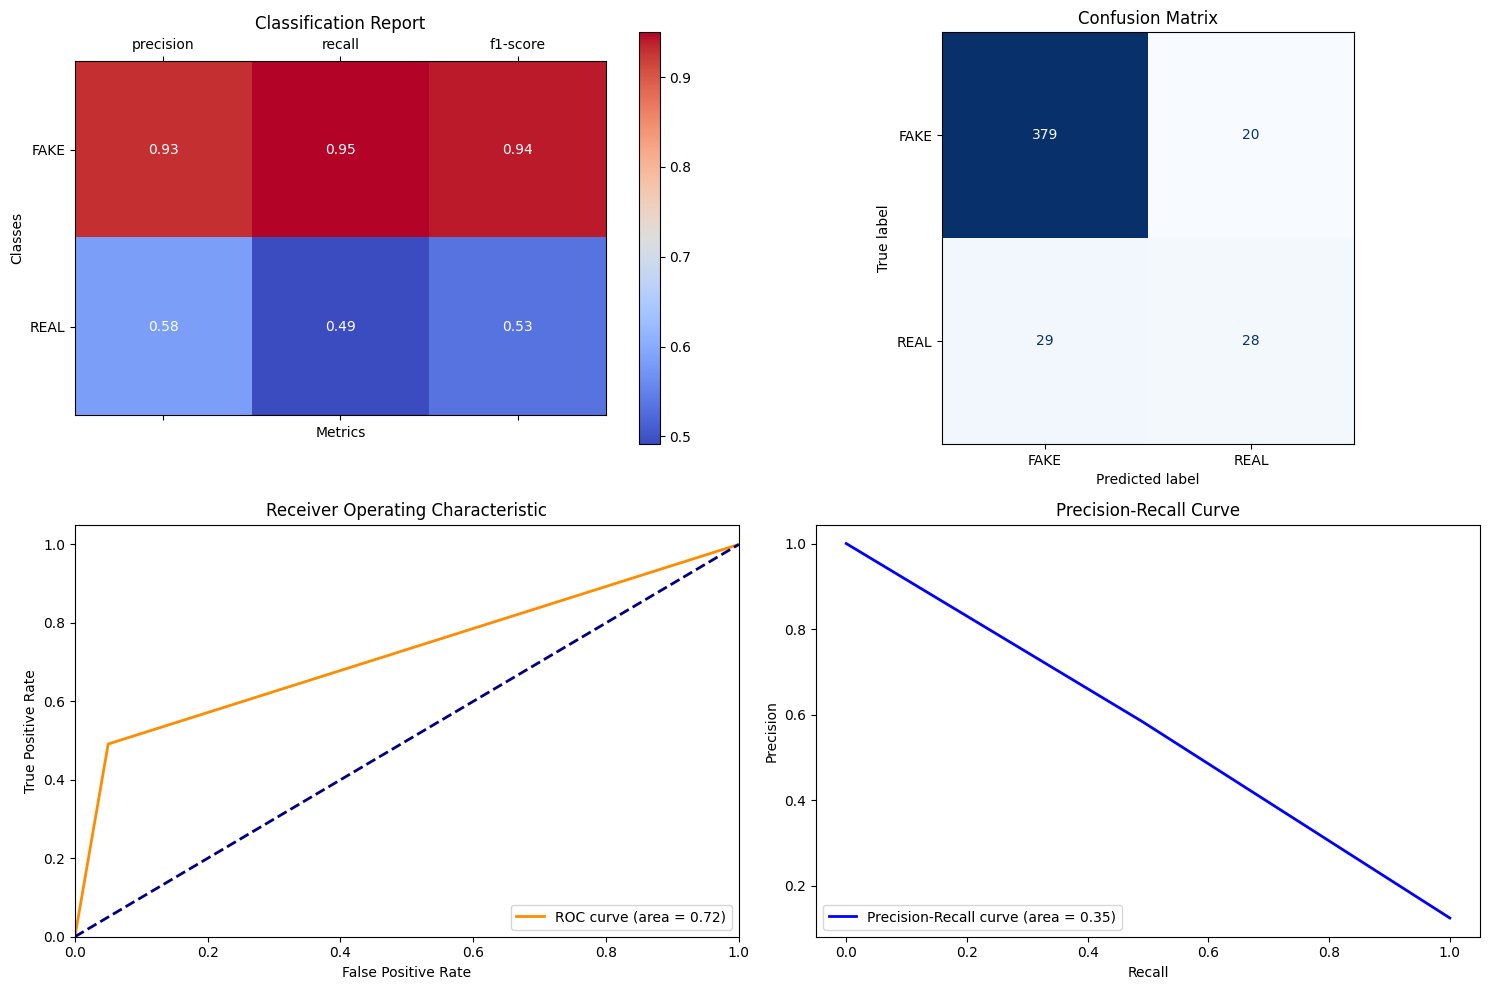

In [61]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "nn2_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_nn_dataloader, device)

In [80]:
# Define model
model = audio_features_nn.AudioFeatureNN1(input_dim, output_dim).to(device)
summary(model, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 26]             702
              ReLU-2                [-1, 1, 26]               0
            Linear-3                [-1, 1, 26]             702
              ReLU-4                [-1, 1, 26]               0
            Linear-5                [-1, 1, 26]             702
              ReLU-6                [-1, 1, 26]               0
            Linear-7                [-1, 1, 26]             702
              ReLU-8                [-1, 1, 26]               0
            Linear-9                [-1, 1, 26]             702
             ReLU-10                [-1, 1, 26]               0
           Linear-11                 [-1, 1, 1]              27
          Sigmoid-12                 [-1, 1, 1]               0
Total params: 3,537
Trainable params: 3,537
Non-trainable params: 0
-----------------------------------

Epoch 1/100, Train Loss: 0.9202, Train Acc: 0.8315, Val Loss: 0.9353, Val Acc: 0.8382, Val Precision: 0.4286, Val Recall: 0.8824, Val F1: 0.5769
Model saved at epoch 1
Epoch 2/100, Train Loss: 0.9193, Train Acc: 0.8274, Val Loss: 0.9592, Val Acc: 0.8771, Val Precision: 0.5051, Val Recall: 0.8319, Val F1: 0.6286
Model saved at epoch 2
Epoch 3/100, Train Loss: 0.9186, Train Acc: 0.8094, Val Loss: 0.9514, Val Acc: 0.8603, Val Precision: 0.4670, Val Recall: 0.8319, Val F1: 0.5982
Epoch 4/100, Train Loss: 0.9250, Train Acc: 0.7980, Val Loss: 0.9559, Val Acc: 0.8298, Val Precision: 0.4130, Val Recall: 0.8571, Val F1: 0.5574
Epoch 5/100, Train Loss: 0.9204, Train Acc: 0.8043, Val Loss: 0.9483, Val Acc: 0.8424, Val Precision: 0.4378, Val Recall: 0.9160, Val F1: 0.5924
Epoch 6/100, Train Loss: 0.9180, Train Acc: 0.8338, Val Loss: 0.9424, Val Acc: 0.8382, Val Precision: 0.4303, Val Recall: 0.9076, Val F1: 0.5838
Epoch 7/100, Train Loss: 0.9183, Train Acc: 0.8140, Val Loss: 0.9458, Val Acc: 0.826

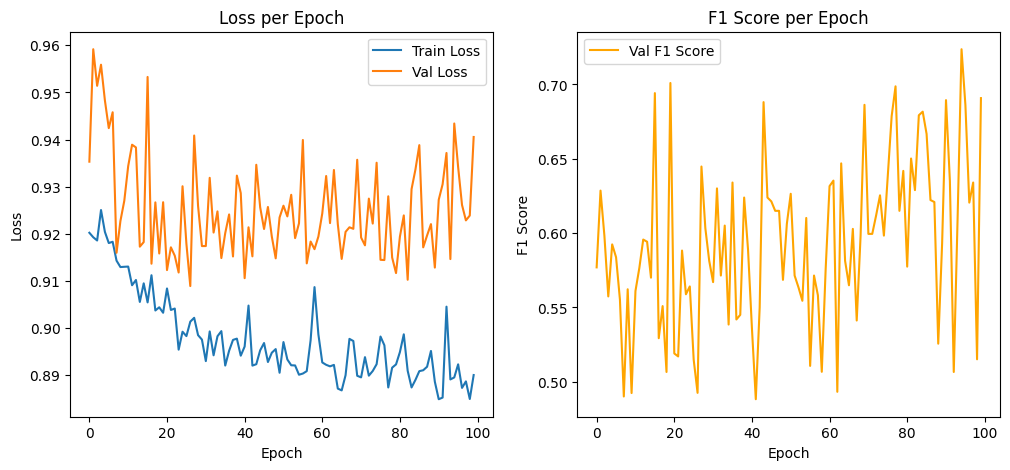

In [85]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 6.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_nn_dataloader,
    val_nn_dataloader,
    num_epochs=100,
    save_path=os.path.join(saved_models_dir, "nn3_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: FAKE  margot-to-obama: FAKE
  ryan-original: REAL   margot-to-ryan: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-obama: FAKE
                        margot-to-musk: FAKE
                         ryan-to-biden: FAKE
                       margot-to-linus: FAKE
                         ryan-to-linus: FAKE
                      margot-to-taylor: FAKE
                        ryan-to-margot: FAKE
                       margot-to-biden: FAKE
                         ryan-to-trump: FAKE
                       margot-to-trump: FAKE
                        ryan-to-taylor: FAKE


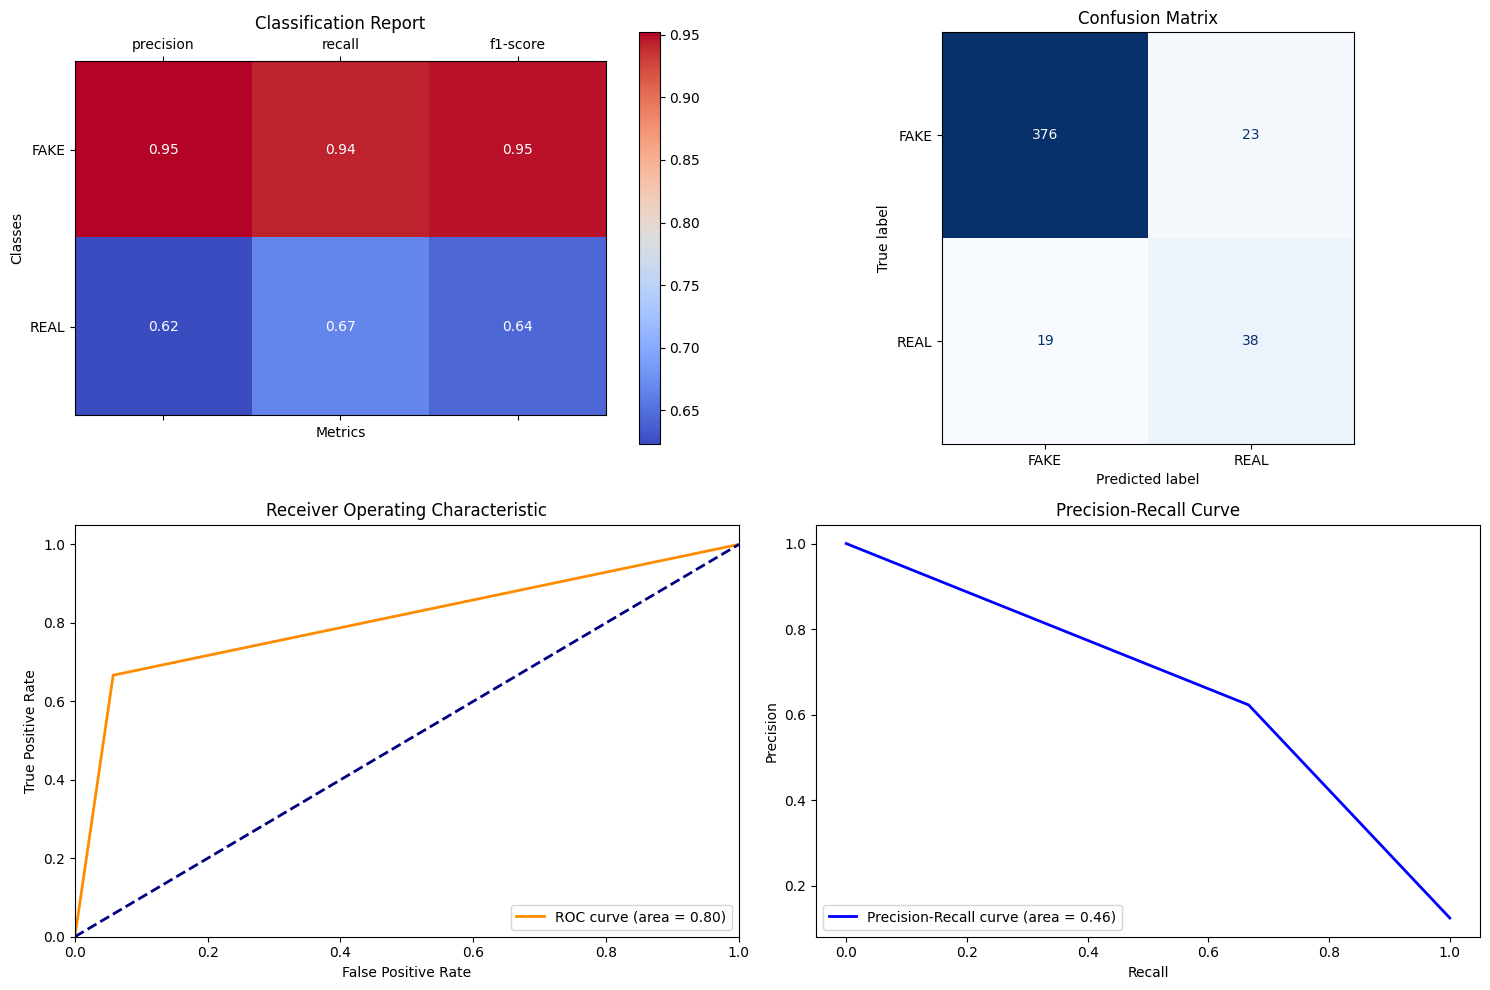

In [87]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "nn3_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_nn_dataloader, device)

In [90]:
# Define model
model = audio_features_nn.AudioFeatureNN2(input_dim, output_dim, dropout_prob=0).to(
    device
)
summary(model, (1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 52]           1,404
              ReLU-2                [-1, 1, 52]               0
           Dropout-3                [-1, 1, 52]               0
            Linear-4               [-1, 1, 104]           5,512
              ReLU-5               [-1, 1, 104]               0
           Dropout-6               [-1, 1, 104]               0
            Linear-7                [-1, 1, 52]           5,460
              ReLU-8                [-1, 1, 52]               0
           Dropout-9                [-1, 1, 52]               0
           Linear-10                [-1, 1, 26]           1,378
             ReLU-11                [-1, 1, 26]               0
          Dropout-12                [-1, 1, 26]               0
           Linear-13                 [-1, 1, 1]              27
          Sigmoid-14                 [-

Epoch 1/70, Train Loss: 1.1123, Train Acc: 0.1719, Val Loss: 1.0273, Val Acc: 0.2626, Val Precision: 0.1432, Val Recall: 0.9832, Val F1: 0.2500
Model saved at epoch 1
Epoch 2/70, Train Loss: 1.0173, Train Acc: 0.2966, Val Loss: 1.0019, Val Acc: 0.3382, Val Precision: 0.1561, Val Recall: 0.9748, Val F1: 0.2691
Model saved at epoch 2
Epoch 3/70, Train Loss: 1.0015, Train Acc: 0.3521, Val Loss: 0.9841, Val Acc: 0.3992, Val Precision: 0.1674, Val Recall: 0.9580, Val F1: 0.2850
Model saved at epoch 3
Epoch 4/70, Train Loss: 0.9803, Train Acc: 0.4066, Val Loss: 0.9795, Val Acc: 0.4149, Val Precision: 0.1741, Val Recall: 0.9832, Val F1: 0.2958
Model saved at epoch 4
Epoch 5/70, Train Loss: 0.9745, Train Acc: 0.4250, Val Loss: 0.9933, Val Acc: 0.4800, Val Precision: 0.1918, Val Recall: 0.9832, Val F1: 0.3210
Model saved at epoch 5
Epoch 6/70, Train Loss: 0.9567, Train Acc: 0.5228, Val Loss: 0.9622, Val Acc: 0.5347, Val Precision: 0.2065, Val Recall: 0.9580, Val F1: 0.3398
Model saved at epoch 

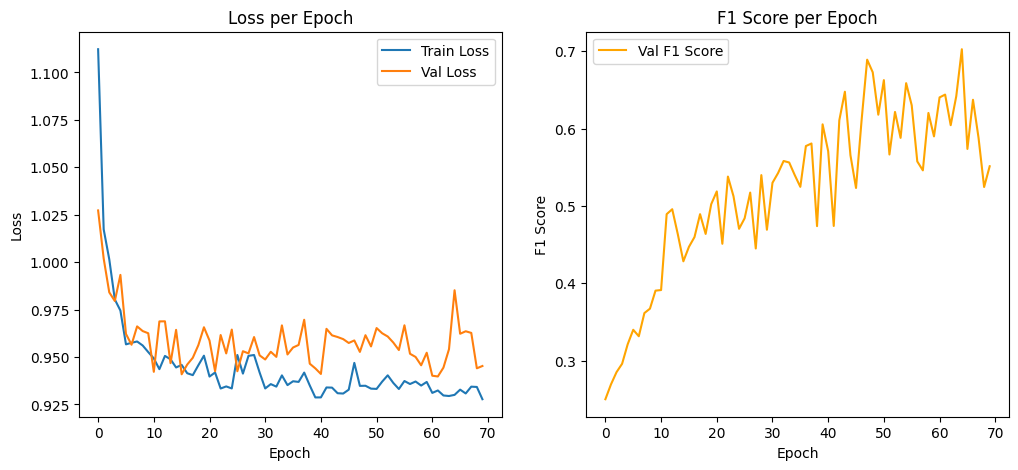

In [91]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 7.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_nn_dataloader,
    val_nn_dataloader,
    num_epochs=70,
    save_path=os.path.join(saved_models_dir, "nn4_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: REAL  margot-to-trump: FAKE
  ryan-original: FAKE margot-to-taylor: FAKE
                         ryan-to-obama: FAKE
                       margot-to-linus: FAKE
                        margot-to-ryan: FAKE
                       margot-to-biden: FAKE
                        ryan-to-margot: FAKE
                       margot-to-obama: FAKE
                         ryan-to-linus: FAKE
                         ryan-to-biden: FAKE
                         ryan-to-trump: FAKE
                        margot-to-musk: FAKE
                        ryan-to-taylor: FAKE
                          ryan-to-musk: FAKE


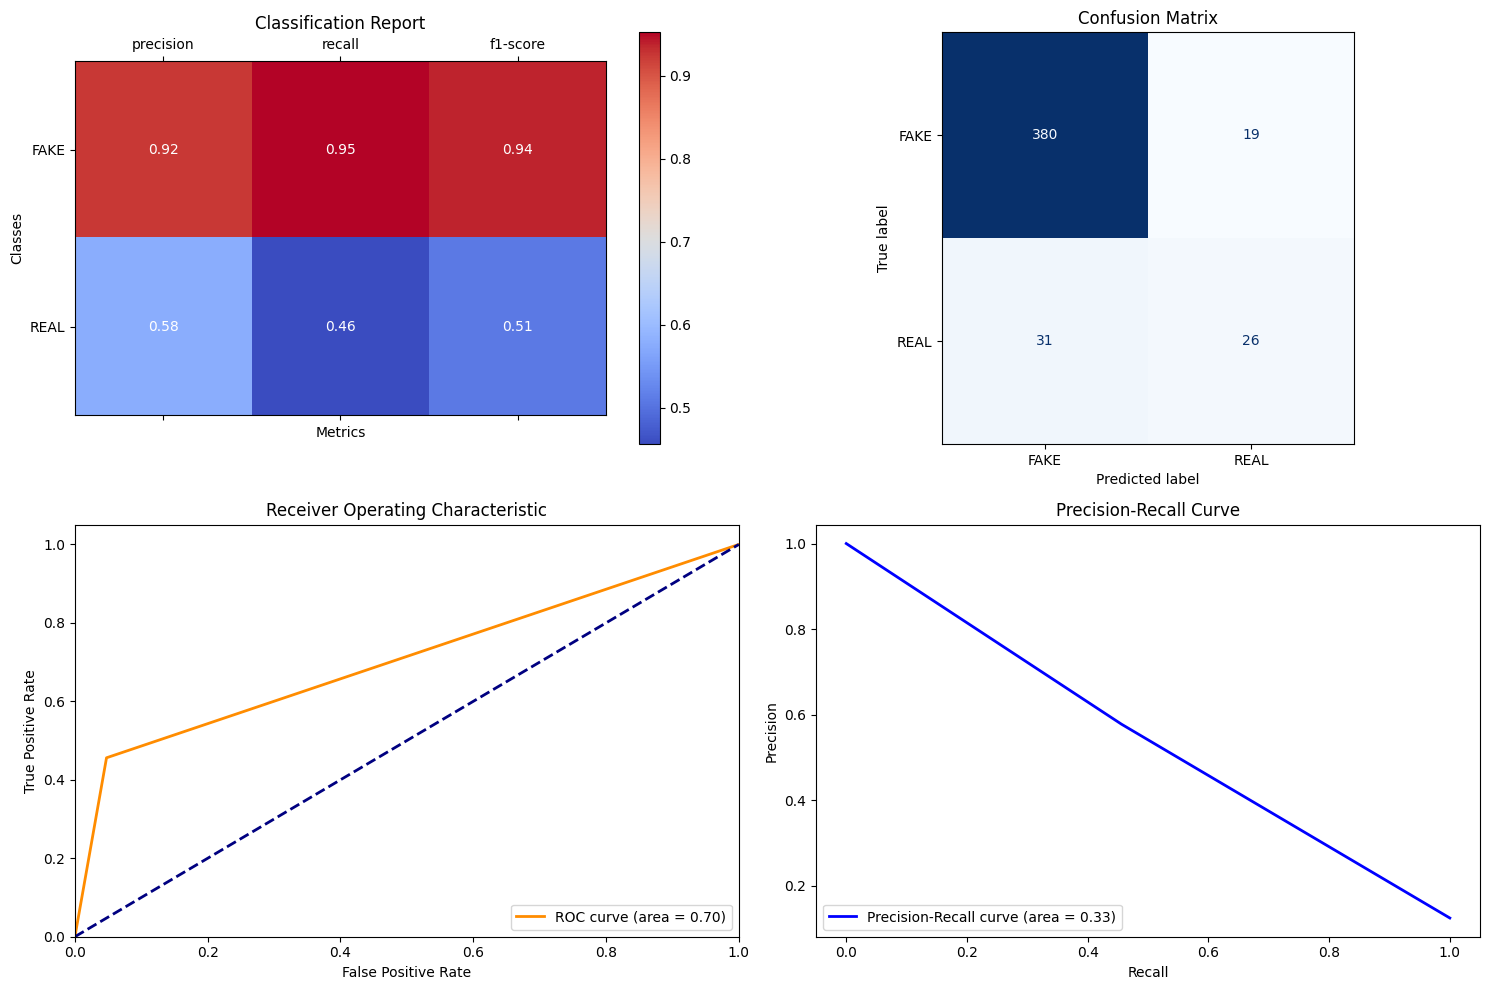

In [92]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "nn4_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_nn_dataloader, device)

#### CNN

In [211]:
# Define model
model = audio_features_cnn.AudioFeatureCNN1().to(device)
summary(model, (1, 26))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 16, 26]              64
              ReLU-2               [-1, 16, 26]               0
         MaxPool1d-3               [-1, 16, 13]               0
           Dropout-4               [-1, 16, 13]               0
            Conv1d-5               [-1, 32, 13]           1,568
              ReLU-6               [-1, 32, 13]               0
         MaxPool1d-7                [-1, 32, 6]               0
           Dropout-8                [-1, 32, 6]               0
            Conv1d-9                [-1, 64, 6]           6,208
             ReLU-10                [-1, 64, 6]               0
        MaxPool1d-11                [-1, 64, 3]               0
          Dropout-12                [-1, 64, 3]               0
          Flatten-13                  [-1, 192]               0
           Linear-14                   

Epoch 1/50, Train Loss: 1.0933, Train Acc: 0.5754, Val Loss: 0.9608, Val Acc: 0.6366, Val Precision: 0.2304, Val Recall: 0.8151, Val F1: 0.3593
Model saved at epoch 1
Epoch 2/50, Train Loss: 0.9701, Train Acc: 0.6876, Val Loss: 0.8656, Val Acc: 0.6492, Val Precision: 0.2471, Val Recall: 0.8824, Val F1: 0.3860
Model saved at epoch 2
Epoch 3/50, Train Loss: 0.9225, Train Acc: 0.7135, Val Loss: 0.8112, Val Acc: 0.6870, Val Precision: 0.2651, Val Recall: 0.8487, Val F1: 0.4040
Model saved at epoch 3
Epoch 4/50, Train Loss: 0.8821, Train Acc: 0.7394, Val Loss: 0.7788, Val Acc: 0.8561, Val Precision: 0.4531, Val Recall: 0.7311, Val F1: 0.5595
Model saved at epoch 4
Epoch 5/50, Train Loss: 0.8480, Train Acc: 0.7682, Val Loss: 0.7319, Val Acc: 0.7521, Val Precision: 0.3200, Val Recall: 0.8739, Val F1: 0.4685
Epoch 6/50, Train Loss: 0.8040, Train Acc: 0.7639, Val Loss: 0.6890, Val Acc: 0.8015, Val Precision: 0.3759, Val Recall: 0.8908, Val F1: 0.5287
Epoch 7/50, Train Loss: 0.7873, Train Acc: 0

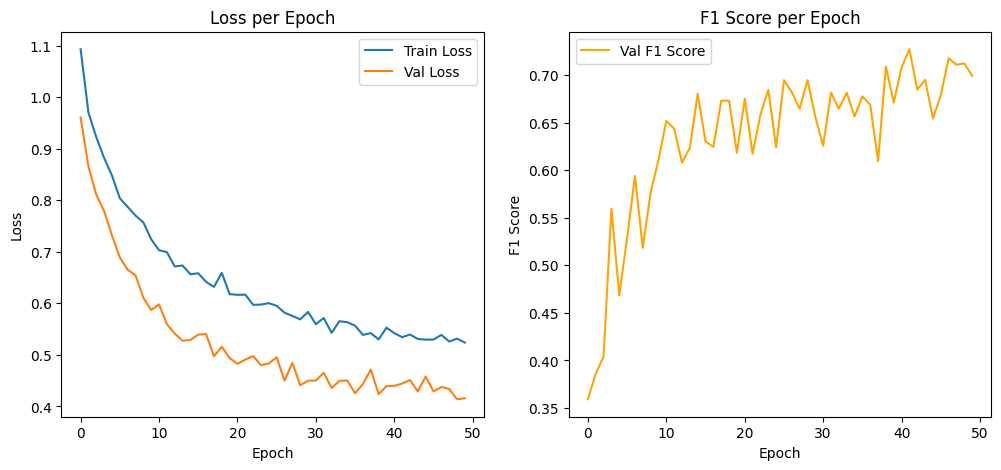

In [212]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 7.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_cnn_dataloader,
    val_cnn_dataloader,
    num_epochs=50,
    save_path=os.path.join(saved_models_dir, "cnn1_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: FAKE     ryan-to-musk: FAKE
  ryan-original: FAKE  margot-to-trump: FAKE
                        margot-to-ryan: FAKE
                         ryan-to-linus: FAKE
                         ryan-to-obama: FAKE
                       margot-to-obama: FAKE
                         ryan-to-biden: FAKE
                       margot-to-linus: FAKE
                         ryan-to-trump: FAKE
                        margot-to-musk: FAKE
                       margot-to-biden: FAKE
                      margot-to-taylor: FAKE
                        ryan-to-taylor: FAKE
                        ryan-to-margot: FAKE


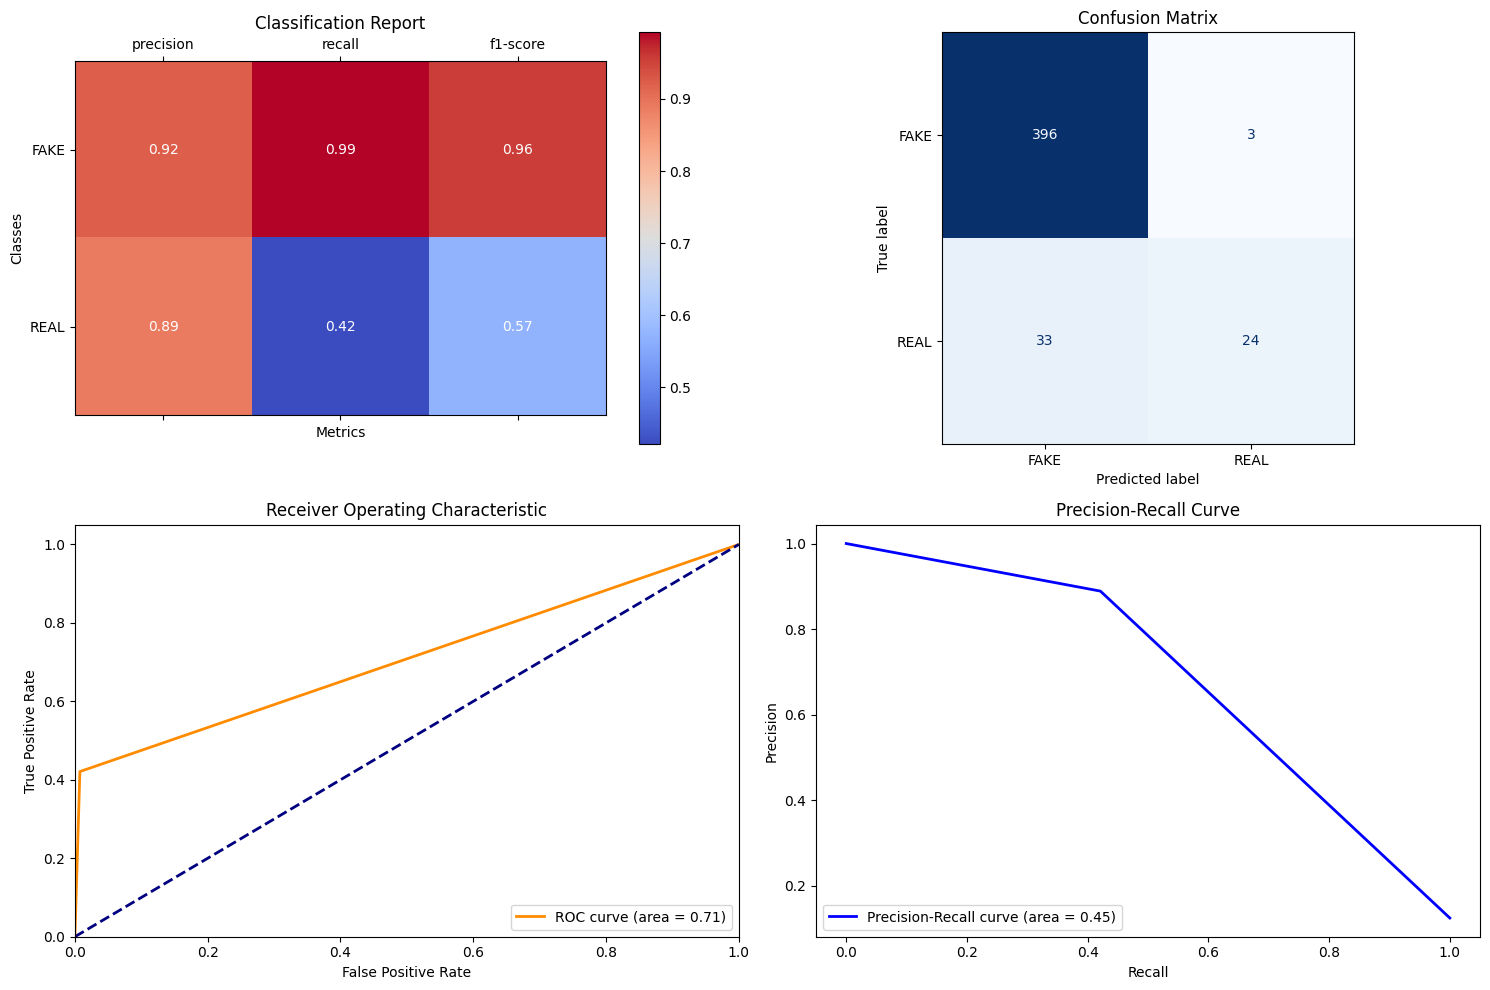

In [213]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn1_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_cnn_dataloader, device)

In [264]:
# Define model
model = audio_features_cnn.AudioFeatureCNN2().to(device)
summary(model, (1, 26))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 26]             128
              ReLU-2               [-1, 32, 26]               0
         MaxPool1d-3               [-1, 32, 13]               0
            Conv1d-4               [-1, 64, 13]           6,208
              ReLU-5               [-1, 64, 13]               0
         MaxPool1d-6                [-1, 64, 6]               0
            Conv1d-7               [-1, 128, 6]          24,704
              ReLU-8               [-1, 128, 6]               0
         MaxPool1d-9               [-1, 128, 3]               0
          Flatten-10                  [-1, 384]               0
           Linear-11                  [-1, 192]          73,920
             ReLU-12                  [-1, 192]               0
          Dropout-13                  [-1, 192]               0
           Linear-14                   

Epoch 1/50, Train Loss: 1.1064, Train Acc: 0.4917, Val Loss: 0.9947, Val Acc: 0.6712, Val Precision: 0.2364, Val Recall: 0.7311, Val F1: 0.3573
Model saved at epoch 1
Epoch 2/50, Train Loss: 0.9752, Train Acc: 0.6601, Val Loss: 0.9229, Val Acc: 0.7153, Val Precision: 0.2548, Val Recall: 0.6639, Val F1: 0.3683
Model saved at epoch 2
Epoch 3/50, Train Loss: 0.9061, Train Acc: 0.7072, Val Loss: 0.8976, Val Acc: 0.8582, Val Precision: 0.4459, Val Recall: 0.5546, Val F1: 0.4944
Model saved at epoch 3
Epoch 4/50, Train Loss: 0.8431, Train Acc: 0.7617, Val Loss: 0.7902, Val Acc: 0.7847, Val Precision: 0.3442, Val Recall: 0.7983, Val F1: 0.4810
Epoch 5/50, Train Loss: 0.7753, Train Acc: 0.7899, Val Loss: 0.7537, Val Acc: 0.8624, Val Precision: 0.4667, Val Recall: 0.7059, Val F1: 0.5619
Model saved at epoch 5
Epoch 6/50, Train Loss: 0.7180, Train Acc: 0.8204, Val Loss: 0.7108, Val Acc: 0.8813, Val Precision: 0.5181, Val Recall: 0.7227, Val F1: 0.6035
Model saved at epoch 6
Epoch 7/50, Train Los

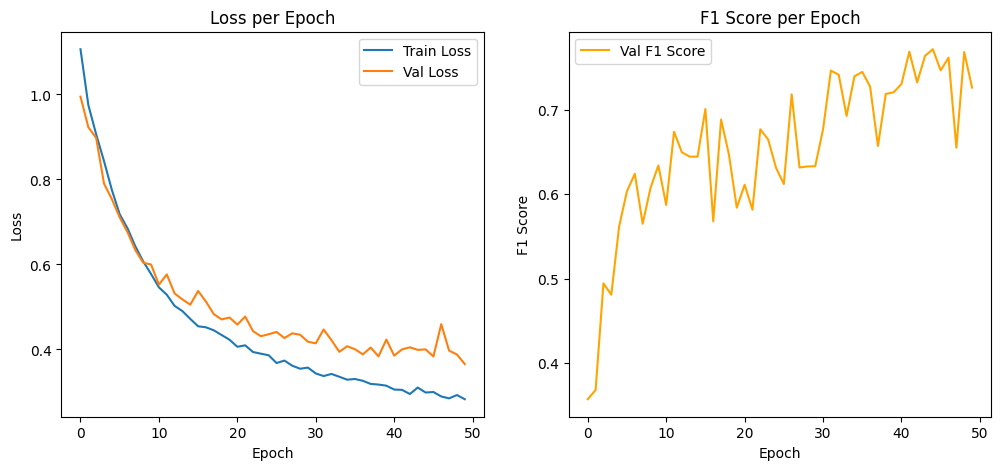

In [265]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 7.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.007)
train.train_model(
    model,
    criterion,
    optimizer,
    train_cnn_dataloader,
    val_cnn_dataloader,
    num_epochs=50,
    save_path=os.path.join(saved_models_dir, "cnn2_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: FAKE   ryan-to-taylor: FAKE
margot-original: FAKE    ryan-to-obama: FAKE
                         ryan-to-linus: FAKE
                       margot-to-linus: FAKE
                      margot-to-taylor: FAKE
                         ryan-to-trump: FAKE
                       margot-to-trump: FAKE
                       margot-to-obama: FAKE
                        margot-to-ryan: FAKE
                          ryan-to-musk: FAKE
                       margot-to-biden: FAKE
                        ryan-to-margot: FAKE
                         ryan-to-biden: FAKE
                        margot-to-musk: FAKE


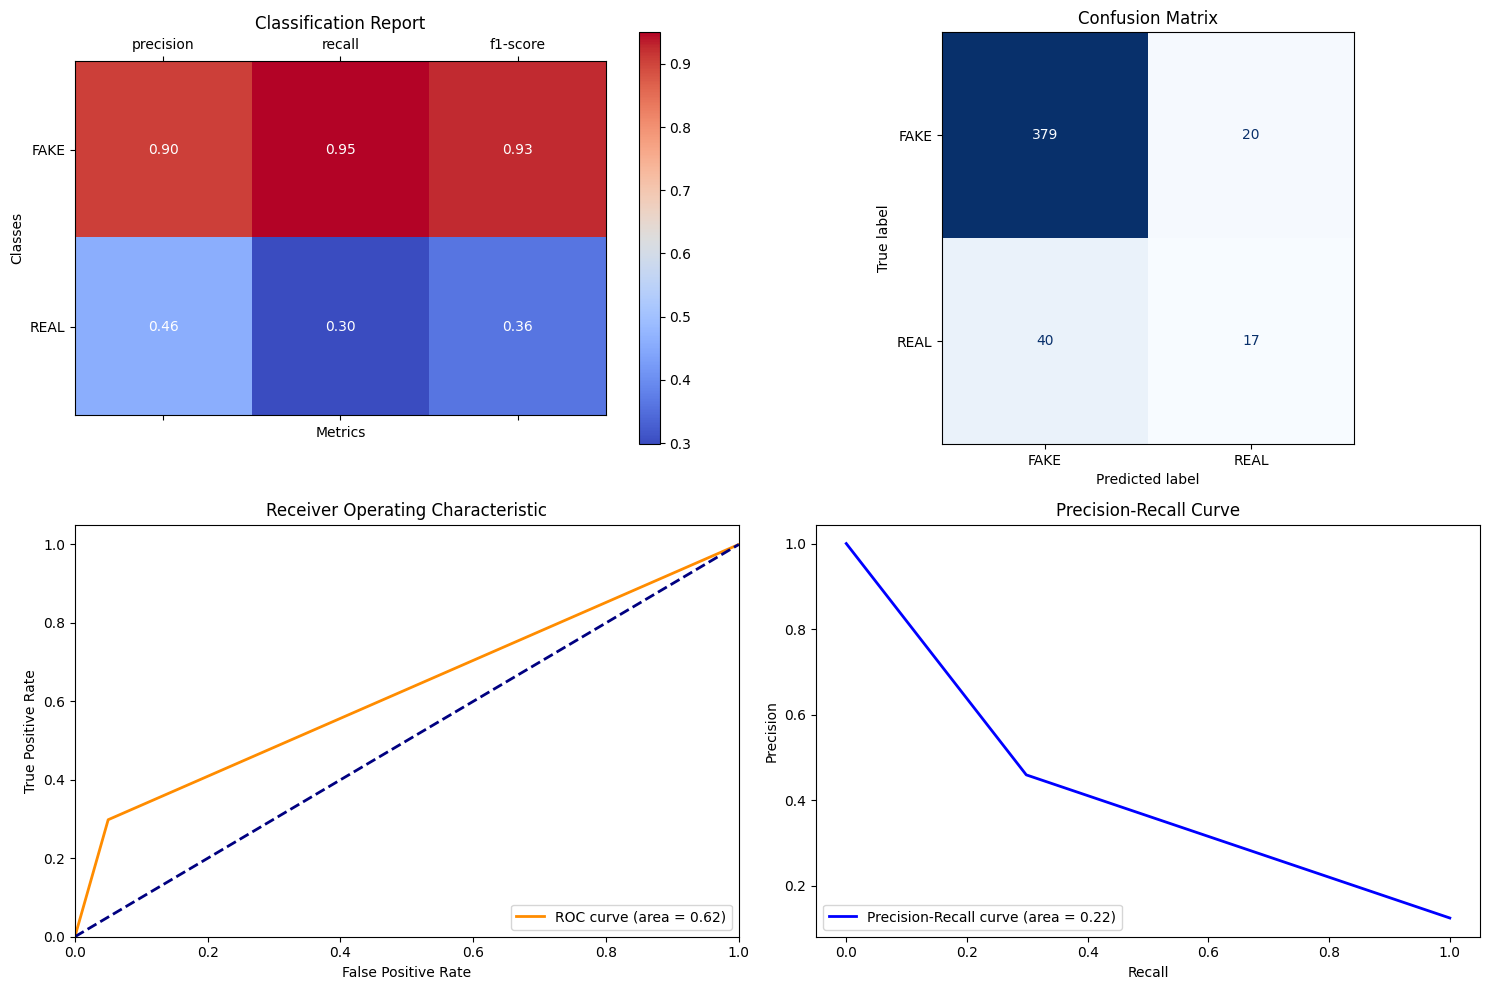

In [266]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn2_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_cnn_dataloader, device)

In [260]:
# Define model
model = audio_features_cnn.AudioFeatureCNN3().to(device)
summary(model, (1, 26))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 26]             128
              ReLU-2               [-1, 32, 26]               0
         MaxPool1d-3               [-1, 32, 13]               0
            Conv1d-4               [-1, 16, 13]           1,552
              ReLU-5               [-1, 16, 13]               0
         MaxPool1d-6                [-1, 16, 6]               0
            Conv1d-7                 [-1, 8, 6]             392
              ReLU-8                 [-1, 8, 6]               0
         MaxPool1d-9                 [-1, 8, 3]               0
          Flatten-10                   [-1, 24]               0
           Linear-11                   [-1, 12]             300
             ReLU-12                   [-1, 12]               0
           Linear-13                    [-1, 1]              13
Total params: 2,385
Trainable params: 2

Epoch 1/30, Train Loss: 1.0527, Train Acc: 0.5326, Val Loss: 0.8869, Val Acc: 0.6555, Val Precision: 0.2494, Val Recall: 0.8739, Val F1: 0.3881
Model saved at epoch 1
Epoch 2/30, Train Loss: 0.8171, Train Acc: 0.7454, Val Loss: 0.7683, Val Acc: 0.8088, Val Precision: 0.3755, Val Recall: 0.7983, Val F1: 0.5108
Model saved at epoch 2
Epoch 3/30, Train Loss: 0.7048, Train Acc: 0.8033, Val Loss: 0.6928, Val Acc: 0.8803, Val Precision: 0.5143, Val Recall: 0.7563, Val F1: 0.6122
Model saved at epoch 3
Epoch 4/30, Train Loss: 0.6308, Train Acc: 0.8352, Val Loss: 0.6144, Val Acc: 0.9023, Val Precision: 0.5793, Val Recall: 0.7983, Val F1: 0.6714
Model saved at epoch 4
Epoch 5/30, Train Loss: 0.5702, Train Acc: 0.8540, Val Loss: 0.5855, Val Acc: 0.8866, Val Precision: 0.5304, Val Recall: 0.8067, Val F1: 0.6400
Epoch 6/30, Train Loss: 0.5282, Train Acc: 0.8661, Val Loss: 0.5165, Val Acc: 0.8687, Val Precision: 0.4857, Val Recall: 0.8571, Val F1: 0.6201
Epoch 7/30, Train Loss: 0.4893, Train Acc: 0

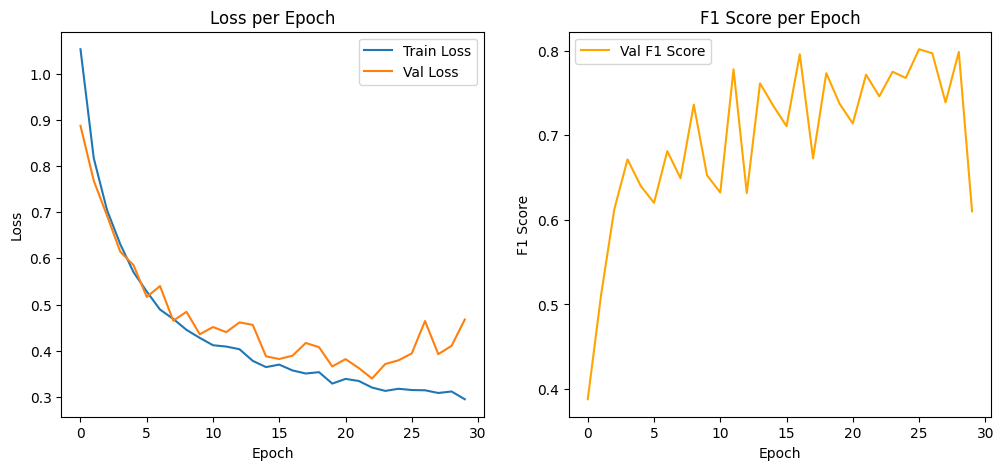

In [261]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 7.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_cnn_dataloader,
    val_cnn_dataloader,
    num_epochs=30,
    save_path=os.path.join(saved_models_dir, "cnn3_audio_features.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: FAKE  margot-to-trump: FAKE
margot-original: FAKE    ryan-to-linus: FAKE
                       margot-to-linus: FAKE
                         ryan-to-biden: FAKE
                        ryan-to-margot: FAKE
                        margot-to-musk: FAKE
                          ryan-to-musk: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-obama: FAKE
                       margot-to-obama: FAKE
                        margot-to-ryan: FAKE
                      margot-to-taylor: FAKE
                         ryan-to-trump: FAKE
                       margot-to-biden: FAKE


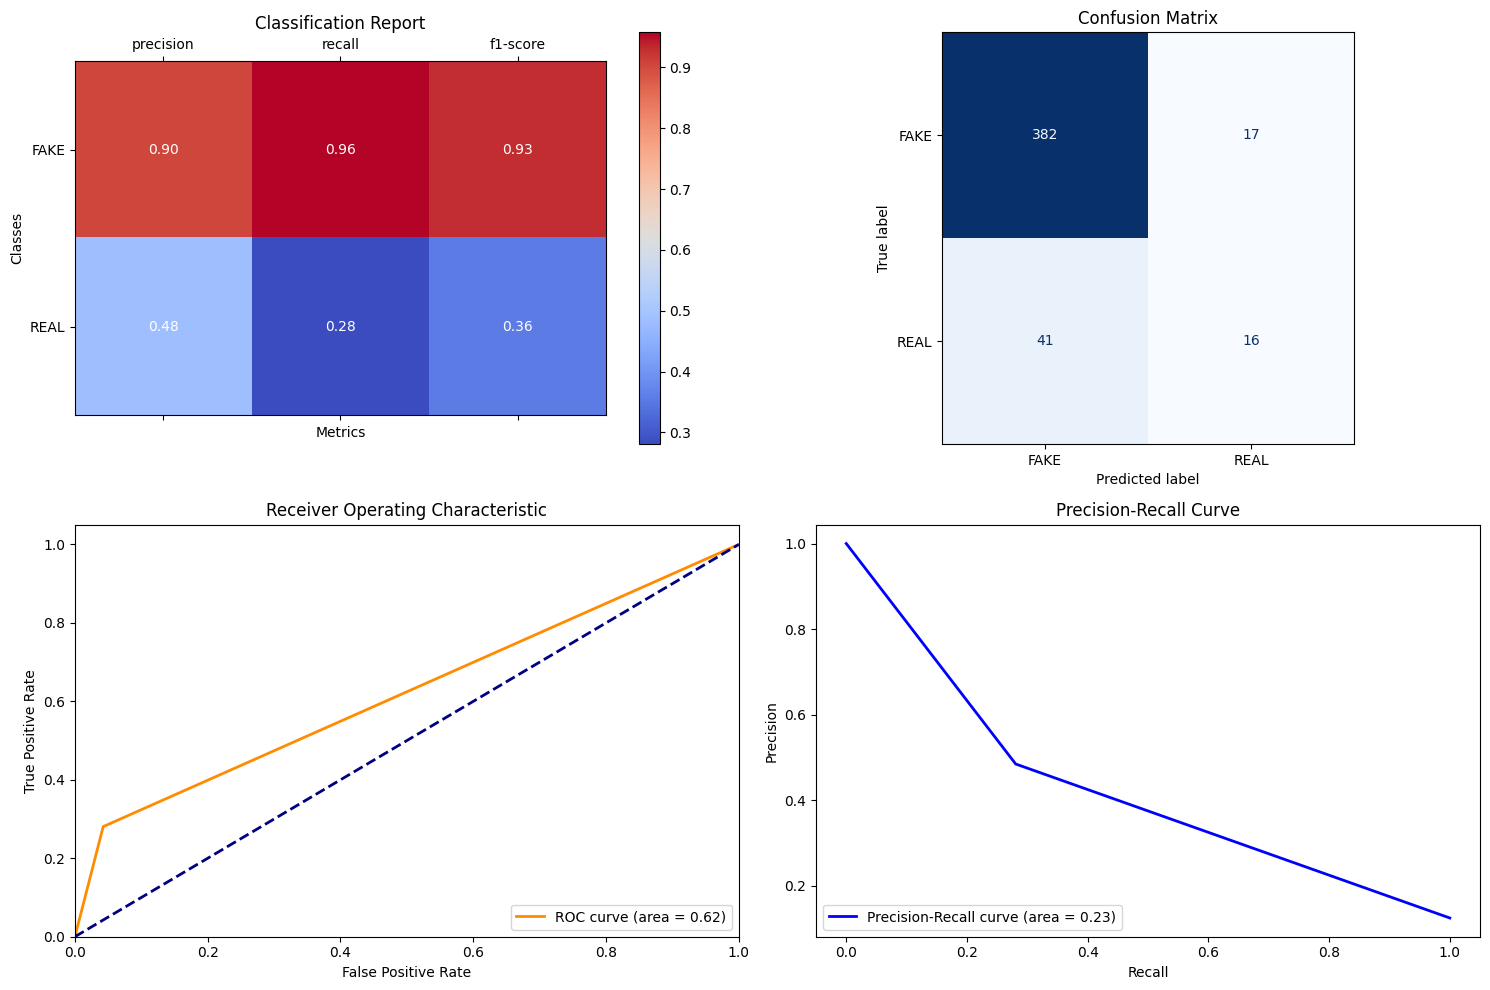

In [263]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn3_audio_features.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_cnn_dataloader, device)

### With Melgrams

#### CNN

- in_channels: how many features are we passing in. Our features are our colour bands, in greyscale, we have 1 feature, in colour, we have 3 channels. <br>
- out_channels: how many kernels do we want to use. Analogous to the number of hidden nodes in a hidden layer of a fully connected network. <br>
- kernel_size: the size of the kernel. Common sizes are 3x3, 5x5, 7x7. <br>
- stride: the "step-size" of the kernel. <br>
- padding: the number of pixels we should pad to the outside of the image so we can get edge pixels. <br>

**Setting padding = kernel_size // 2 will always result in an output the same shape as the input.**

In [152]:
# Define model
model = melgram_cnn.MelgramCNN1().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
           Dropout-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
       BatchNorm2d-7           [-1, 32, 64, 64]              64
              ReLU-8           [-1, 32, 64, 64]               0
         MaxPool2d-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

Epoch 1/20, Train Loss: 2.0310, Train Acc: 0.6092, Val Loss: 1.0477, Val Acc: 0.6355, Val Precision: 0.2062, Val Recall: 0.6723, Val F1: 0.3156
Model saved at epoch 1
Epoch 2/20, Train Loss: 0.9986, Train Acc: 0.6933, Val Loss: 0.9576, Val Acc: 0.7752, Val Precision: 0.2996, Val Recall: 0.5966, Val F1: 0.3989
Model saved at epoch 2
Epoch 3/20, Train Loss: 0.9001, Train Acc: 0.7261, Val Loss: 0.8357, Val Acc: 0.7269, Val Precision: 0.2831, Val Recall: 0.7731, Val F1: 0.4144
Model saved at epoch 3
Epoch 4/20, Train Loss: 0.8459, Train Acc: 0.7525, Val Loss: 1.0574, Val Acc: 0.6807, Val Precision: 0.2100, Val Recall: 0.5630, Val F1: 0.3059
Epoch 5/20, Train Loss: 0.8216, Train Acc: 0.7836, Val Loss: 0.7575, Val Acc: 0.8162, Val Precision: 0.3716, Val Recall: 0.6807, Val F1: 0.4807
Model saved at epoch 5
Epoch 6/20, Train Loss: 0.7811, Train Acc: 0.7914, Val Loss: 0.7211, Val Acc: 0.8908, Val Precision: 0.5743, Val Recall: 0.4874, Val F1: 0.5273
Model saved at epoch 6
Epoch 7/20, Train Los

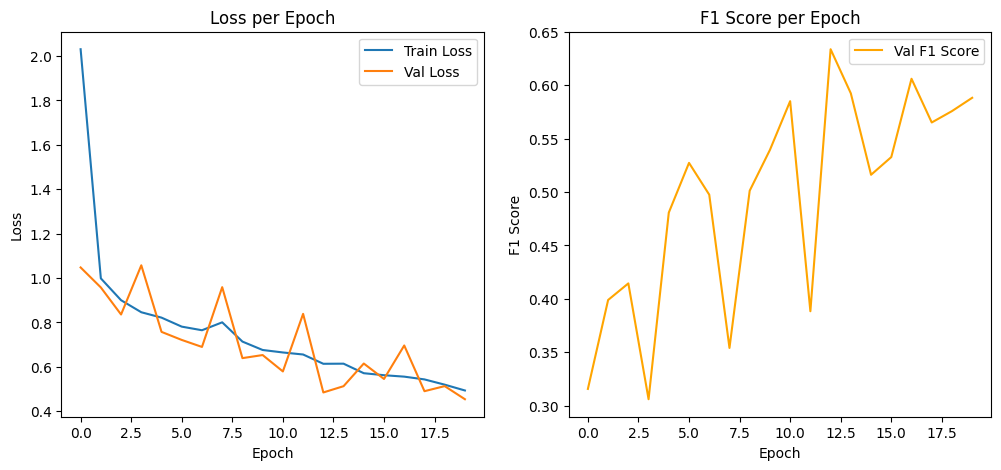

In [153]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 6.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0007)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn1_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL    ryan-to-obama: FAKE
margot-original: REAL   margot-to-musk: FAKE
                       margot-to-linus: FAKE
                          ryan-to-musk: FAKE
                        ryan-to-margot: FAKE
                         ryan-to-linus: FAKE
                       margot-to-obama: FAKE
                         ryan-to-trump: FAKE
                       margot-to-biden: FAKE
                       margot-to-trump: FAKE
                        margot-to-ryan: FAKE
                      margot-to-taylor: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-biden: FAKE


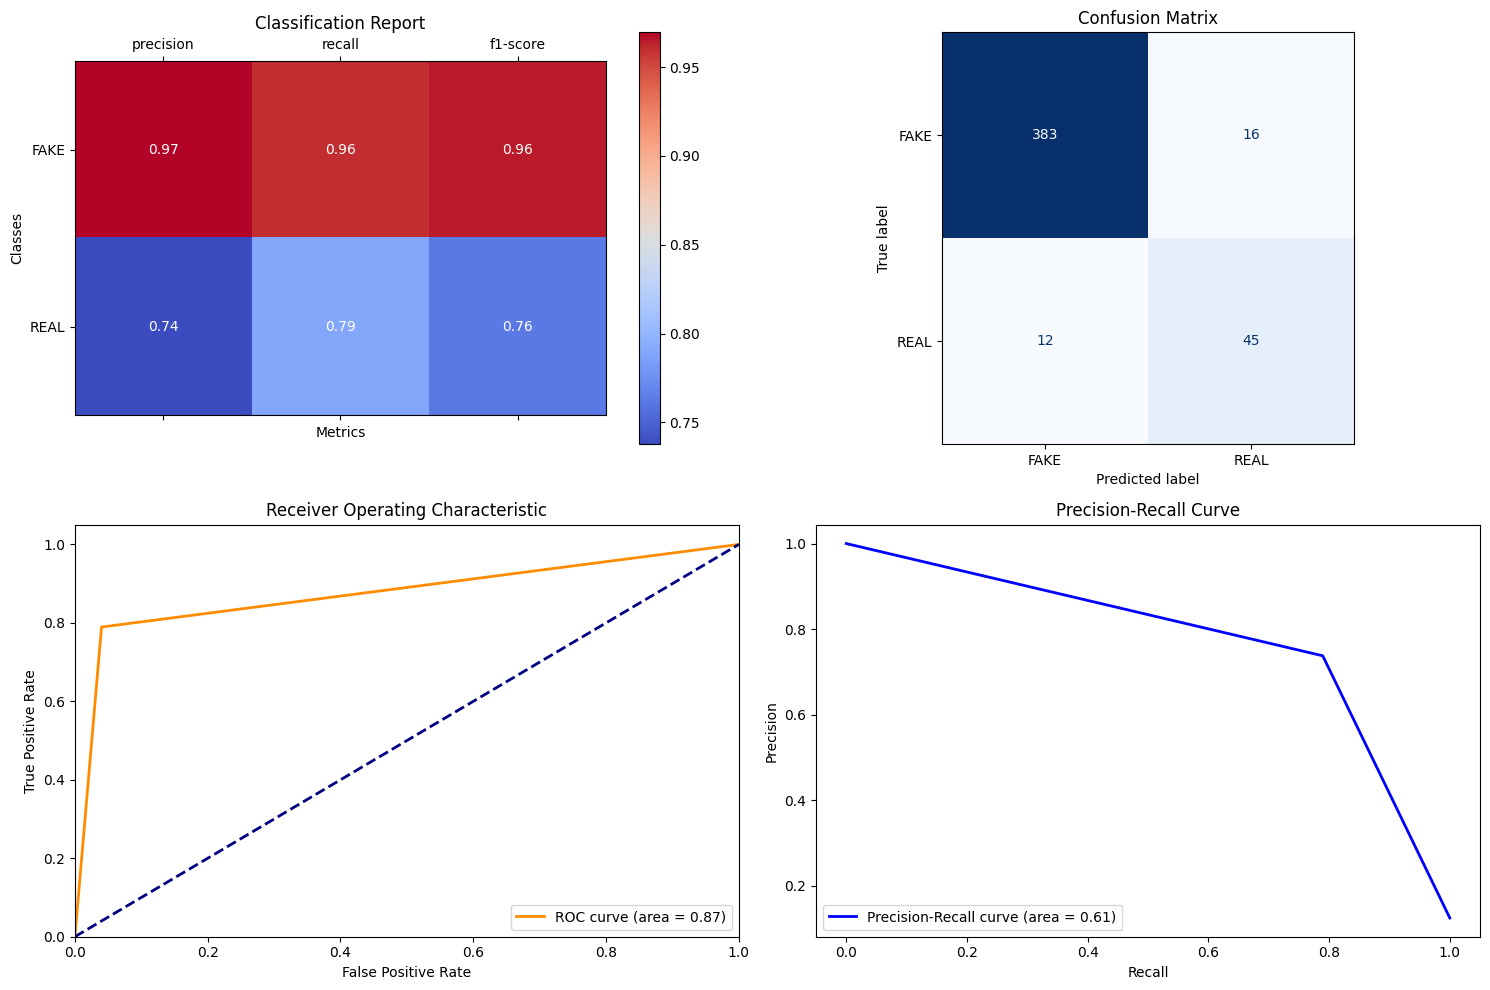

In [155]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn1_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [178]:
# Define model
model = melgram_cnn.MelgramCNN1().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
           Dropout-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
       BatchNorm2d-7           [-1, 32, 64, 64]              64
              ReLU-8           [-1, 32, 64, 64]               0
         MaxPool2d-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

Epoch 1/20, Train Loss: 1.1229, Train Acc: 0.6327, Val Loss: 1.0588, Val Acc: 0.7784, Val Precision: 0.2677, Val Recall: 0.4454, Val F1: 0.3344
Model saved at epoch 1
Epoch 2/20, Train Loss: 1.0459, Train Acc: 0.6752, Val Loss: 1.0412, Val Acc: 0.4611, Val Precision: 0.1792, Val Recall: 0.9244, Val F1: 0.3001
Epoch 3/20, Train Loss: 0.9741, Train Acc: 0.6877, Val Loss: 0.9544, Val Acc: 0.5777, Val Precision: 0.2106, Val Recall: 0.8655, Val F1: 0.3388
Model saved at epoch 3
Epoch 4/20, Train Loss: 0.9045, Train Acc: 0.7194, Val Loss: 0.9576, Val Acc: 0.4706, Val Precision: 0.1870, Val Recall: 0.9664, Val F1: 0.3134
Epoch 5/20, Train Loss: 0.8616, Train Acc: 0.7298, Val Loss: 0.8303, Val Acc: 0.7038, Val Precision: 0.2791, Val Recall: 0.8655, Val F1: 0.4221
Model saved at epoch 5
Epoch 6/20, Train Loss: 0.8162, Train Acc: 0.7457, Val Loss: 1.1526, Val Acc: 0.2752, Val Precision: 0.1445, Val Recall: 0.9748, Val F1: 0.2516
Epoch 7/20, Train Loss: 0.7812, Train Acc: 0.7534, Val Loss: 0.7724

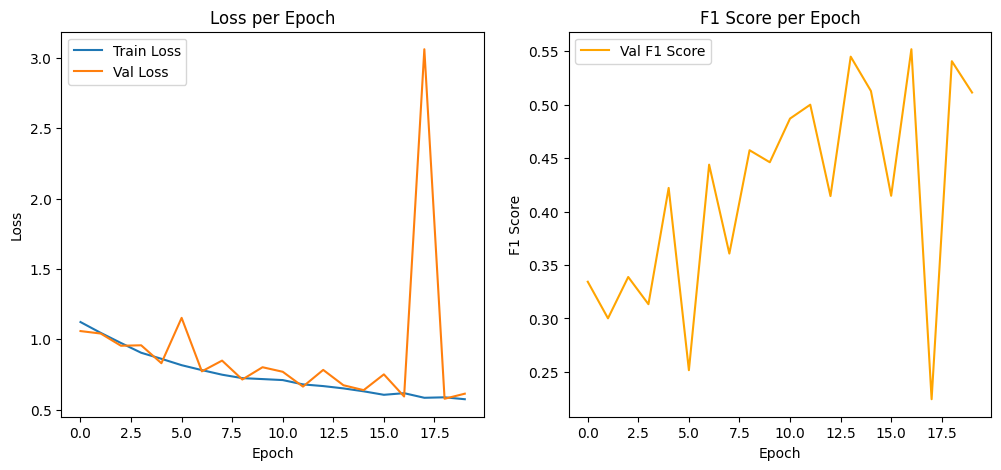

In [179]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 6.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.5,
    weight_decay=0.0001,
)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn2_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL     ryan-to-musk: FAKE
margot-original: REAL  margot-to-trump: FAKE
                       margot-to-linus: FAKE
                        ryan-to-margot: FAKE
                        margot-to-musk: FAKE
                      margot-to-taylor: FAKE
                         ryan-to-trump: FAKE
                         ryan-to-obama: FAKE
                        margot-to-ryan: FAKE
                       margot-to-obama: FAKE
                         ryan-to-linus: FAKE
                       margot-to-biden: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-biden: FAKE


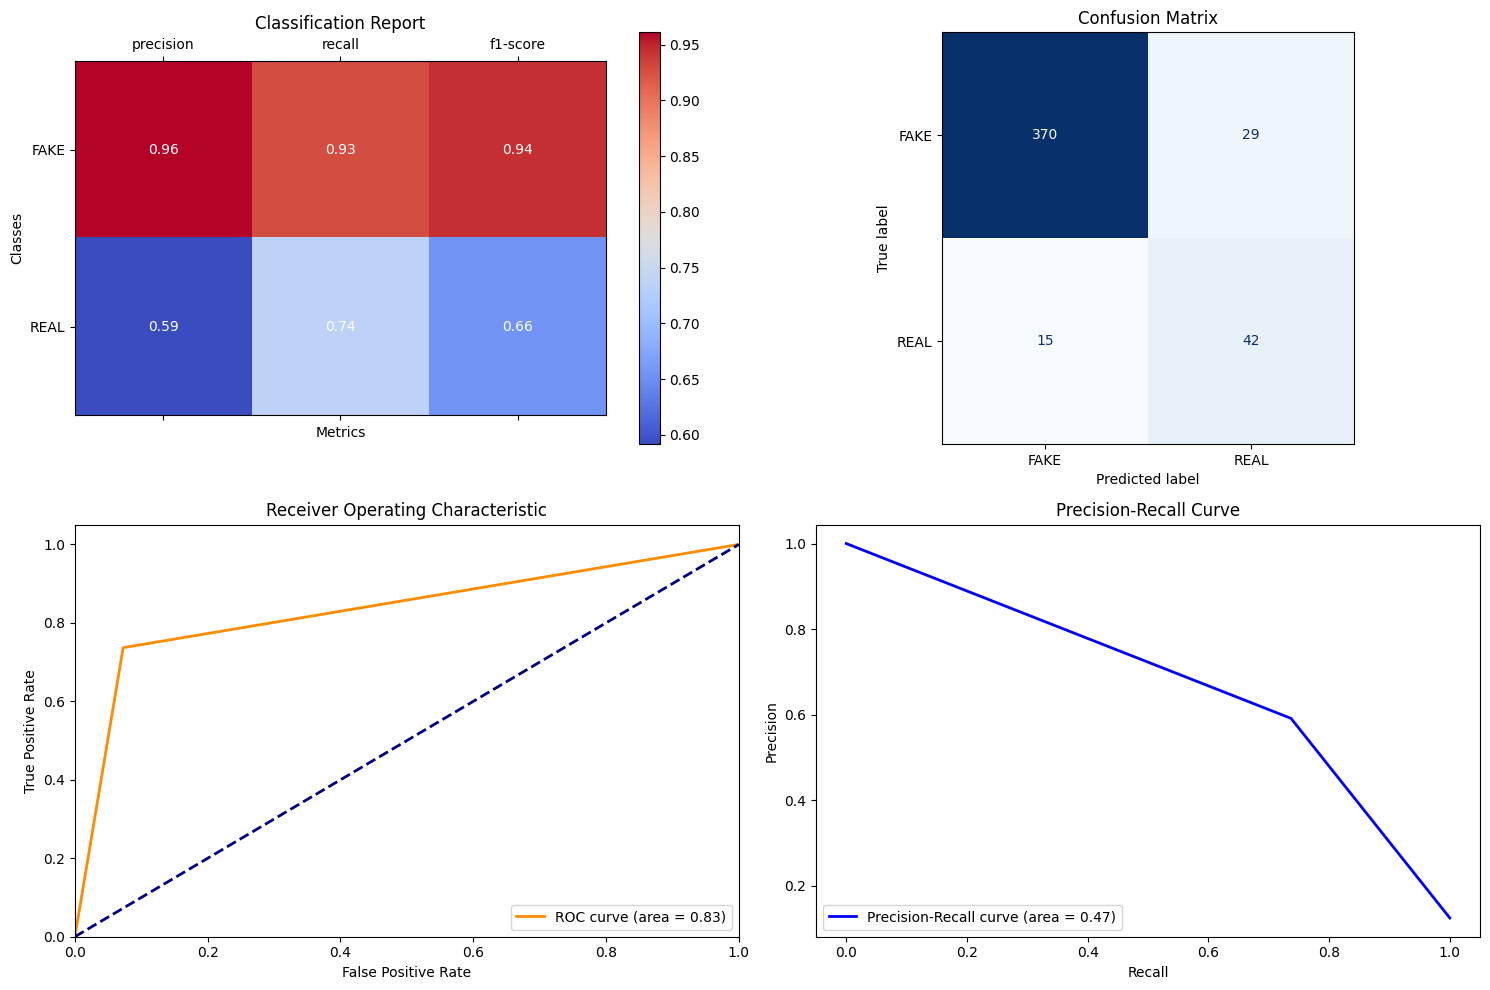

In [180]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn2_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [185]:
# Define model
model = melgram_cnn.MelgramCNN1().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
         MaxPool2d-4           [-1, 16, 64, 64]               0
           Dropout-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
       BatchNorm2d-7           [-1, 32, 64, 64]              64
              ReLU-8           [-1, 32, 64, 64]               0
         MaxPool2d-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

Epoch 1/20, Train Loss: 2.2218, Train Acc: 0.5268, Val Loss: 1.1732, Val Acc: 0.7447, Val Precision: 0.2048, Val Recall: 0.3613, Val F1: 0.2614
Model saved at epoch 1
Epoch 2/20, Train Loss: 1.1863, Train Acc: 0.5327, Val Loss: 1.1075, Val Acc: 0.6523, Val Precision: 0.2166, Val Recall: 0.6807, Val F1: 0.3286
Model saved at epoch 2
Epoch 3/20, Train Loss: 1.1166, Train Acc: 0.6401, Val Loss: 1.0179, Val Acc: 0.6134, Val Precision: 0.2252, Val Recall: 0.8571, Val F1: 0.3566
Model saved at epoch 3
Epoch 4/20, Train Loss: 1.0844, Train Acc: 0.6345, Val Loss: 0.9496, Val Acc: 0.7553, Val Precision: 0.2979, Val Recall: 0.7059, Val F1: 0.4190
Model saved at epoch 4
Epoch 5/20, Train Loss: 1.0354, Train Acc: 0.7059, Val Loss: 0.9714, Val Acc: 0.6660, Val Precision: 0.2259, Val Recall: 0.6891, Val F1: 0.3402
Epoch 6/20, Train Loss: 1.0180, Train Acc: 0.7278, Val Loss: 0.8585, Val Acc: 0.7532, Val Precision: 0.3041, Val Recall: 0.7563, Val F1: 0.4337
Model saved at epoch 6
Epoch 7/20, Train Los

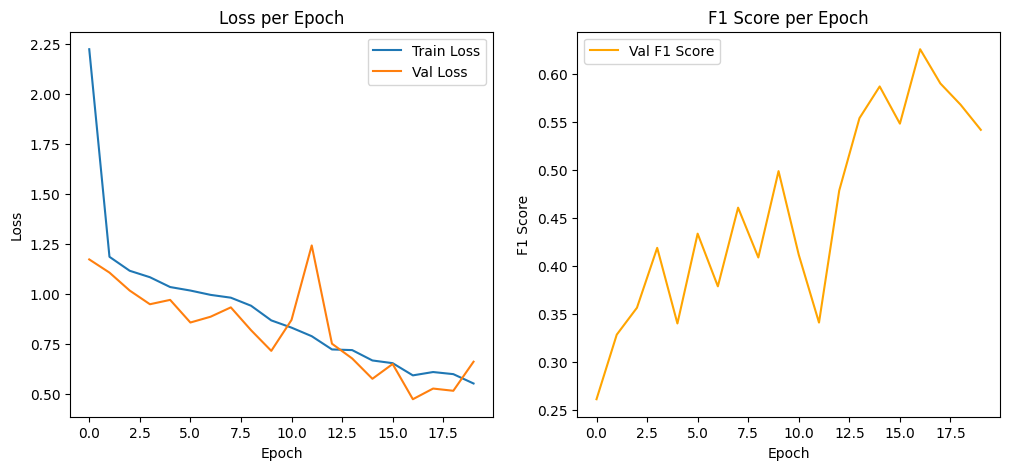

In [186]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 7.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn3_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL    ryan-to-obama: FAKE
margot-original: REAL margot-to-taylor: FAKE
                        margot-to-ryan: FAKE
                       margot-to-trump: FAKE
                         ryan-to-biden: FAKE
                        ryan-to-taylor: FAKE
                        margot-to-musk: FAKE
                       margot-to-biden: FAKE
                        ryan-to-margot: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-trump: FAKE
                         ryan-to-linus: FAKE
                       margot-to-linus: FAKE
                       margot-to-obama: FAKE


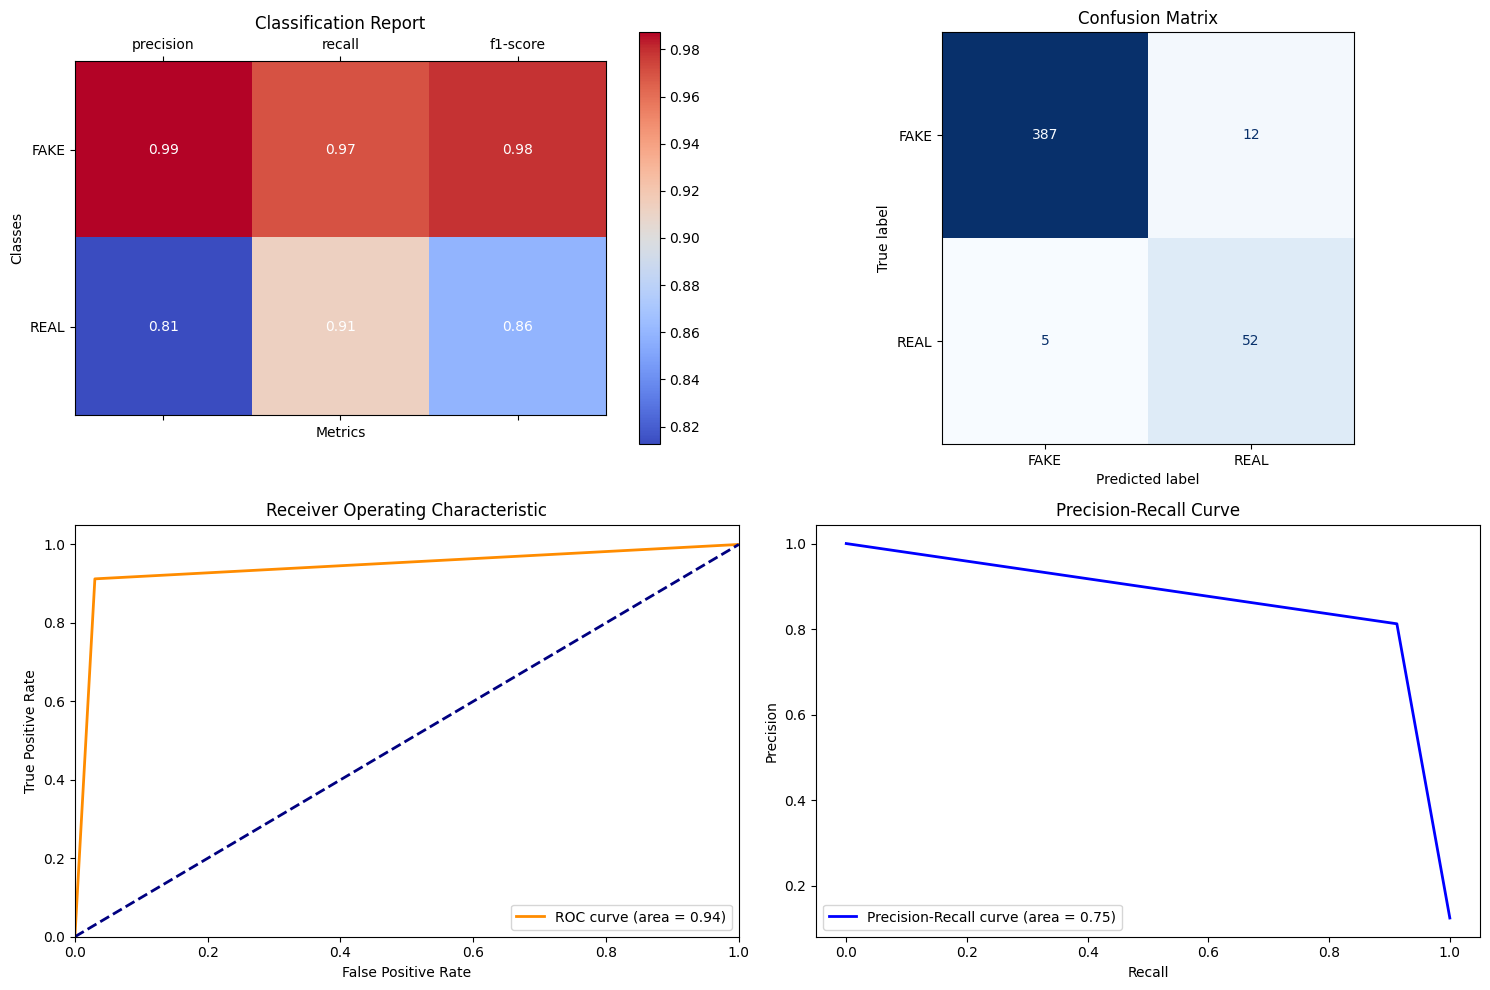

In [188]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn3_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [189]:
# Define model
model = melgram_cnn.MelgramCNN2().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
           Dropout-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

Epoch 1/20, Train Loss: 3.0997, Train Acc: 0.5159, Val Loss: 1.0976, Val Acc: 0.5956, Val Precision: 0.2096, Val Recall: 0.8067, Val F1: 0.3328
Model saved at epoch 1
Epoch 2/20, Train Loss: 1.0511, Train Acc: 0.6004, Val Loss: 0.9403, Val Acc: 0.6523, Val Precision: 0.2476, Val Recall: 0.8739, Val F1: 0.3859
Model saved at epoch 2
Epoch 3/20, Train Loss: 1.0187, Train Acc: 0.6301, Val Loss: 1.0055, Val Acc: 0.5284, Val Precision: 0.1851, Val Recall: 0.8151, Val F1: 0.3017
Epoch 4/20, Train Loss: 0.9460, Train Acc: 0.6789, Val Loss: 0.8587, Val Acc: 0.6261, Val Precision: 0.2373, Val Recall: 0.8992, Val F1: 0.3754
Epoch 5/20, Train Loss: 0.9034, Train Acc: 0.7128, Val Loss: 0.8327, Val Acc: 0.7059, Val Precision: 0.2795, Val Recall: 0.8571, Val F1: 0.4215
Model saved at epoch 5
Epoch 6/20, Train Loss: 0.9020, Train Acc: 0.7334, Val Loss: 0.7793, Val Acc: 0.7468, Val Precision: 0.3106, Val Recall: 0.8403, Val F1: 0.4535
Model saved at epoch 6
Epoch 7/20, Train Loss: 0.8691, Train Acc: 0

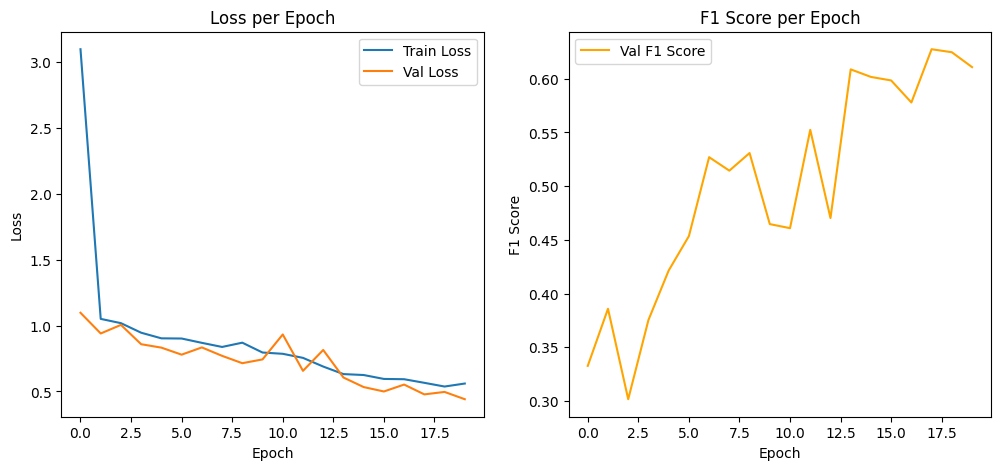

In [190]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 7.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0007)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn4_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: REAL    ryan-to-obama: FAKE
  ryan-original: REAL   ryan-to-taylor: FAKE
                         ryan-to-linus: FAKE
                         ryan-to-trump: FAKE
                          ryan-to-musk: FAKE
                       margot-to-obama: FAKE
                        margot-to-musk: FAKE
                       margot-to-trump: FAKE
                       margot-to-linus: FAKE
                        ryan-to-margot: FAKE
                       margot-to-biden: FAKE
                        margot-to-ryan: FAKE
                         ryan-to-biden: FAKE
                      margot-to-taylor: FAKE


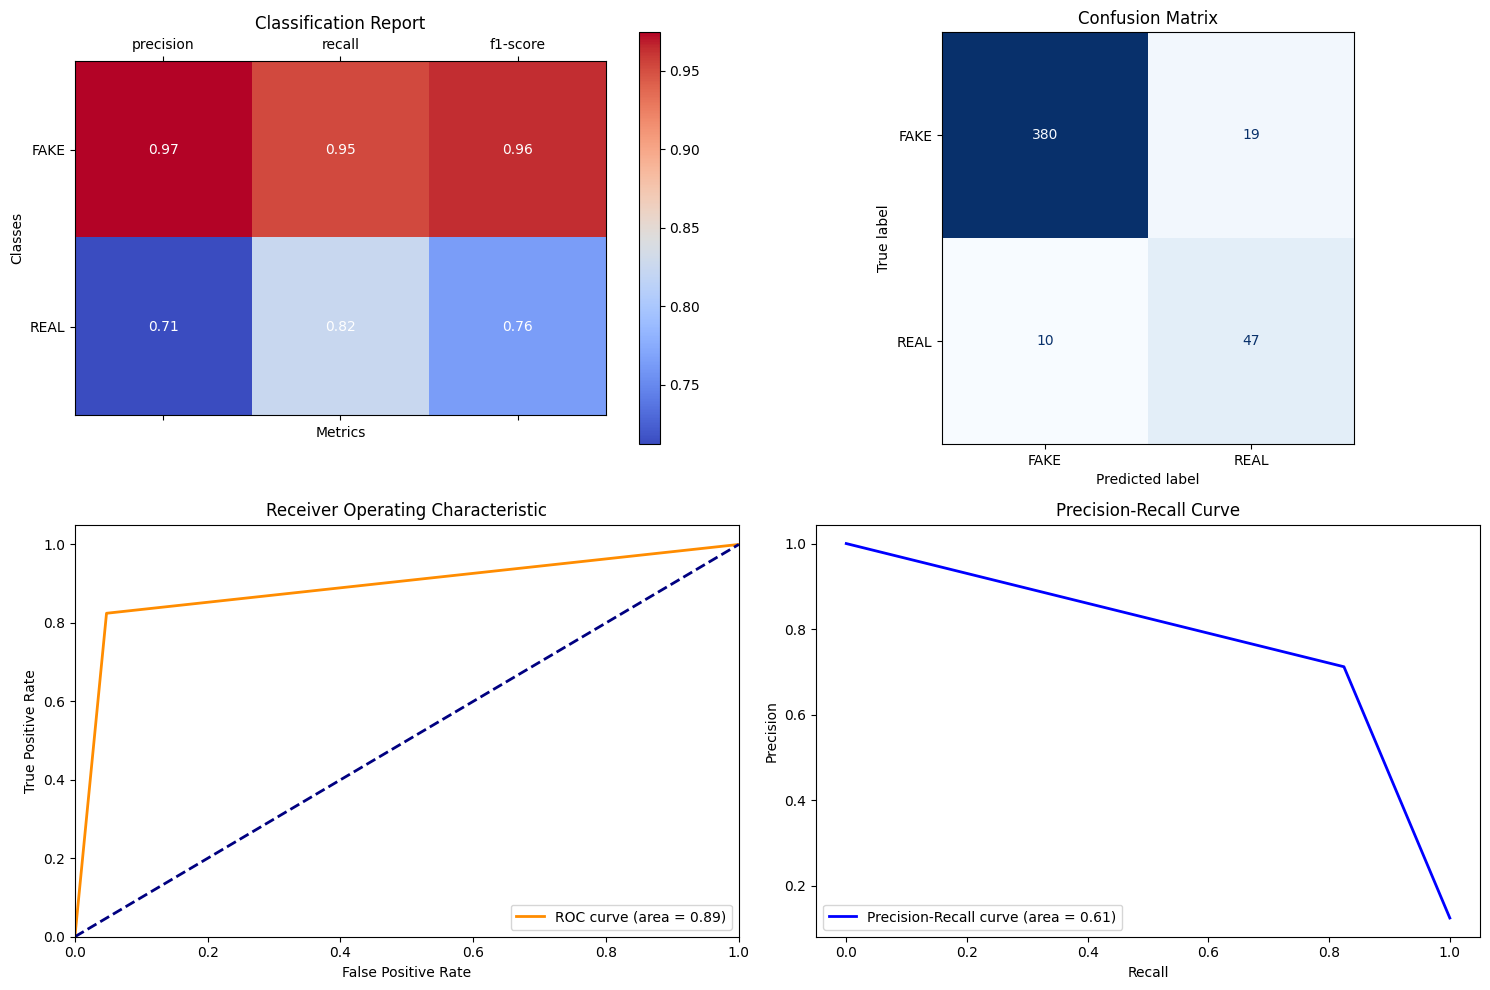

In [191]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn4_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [195]:
# Define model
model = melgram_cnn.MelgramCNN2().to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
           Dropout-5           [-1, 32, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          18,496
       BatchNorm2d-7           [-1, 64, 64, 64]             128
              ReLU-8           [-1, 64, 64, 64]               0
         MaxPool2d-9           [-1, 64, 32, 32]               0
          Dropout-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]          73,856
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

Epoch 1/20, Train Loss: 1.2301, Train Acc: 0.5377, Val Loss: 1.1497, Val Acc: 0.5809, Val Precision: 0.1875, Val Recall: 0.7059, Val F1: 0.2963
Model saved at epoch 1
Epoch 2/20, Train Loss: 1.1624, Train Acc: 0.5952, Val Loss: 1.1233, Val Acc: 0.5452, Val Precision: 0.1770, Val Recall: 0.7227, Val F1: 0.2843
Epoch 3/20, Train Loss: 1.0986, Train Acc: 0.6327, Val Loss: 1.0653, Val Acc: 0.7899, Val Precision: 0.3151, Val Recall: 0.5798, Val F1: 0.4083
Model saved at epoch 3
Epoch 4/20, Train Loss: 1.0191, Train Acc: 0.6732, Val Loss: 1.0349, Val Acc: 0.4538, Val Precision: 0.1729, Val Recall: 0.8908, Val F1: 0.2896
Epoch 5/20, Train Loss: 0.9723, Train Acc: 0.6907, Val Loss: 0.9335, Val Acc: 0.6859, Val Precision: 0.2554, Val Recall: 0.7899, Val F1: 0.3860
Epoch 6/20, Train Loss: 0.9139, Train Acc: 0.7185, Val Loss: 0.9263, Val Acc: 0.5788, Val Precision: 0.2122, Val Recall: 0.8739, Val F1: 0.3415
Epoch 7/20, Train Loss: 0.8744, Train Acc: 0.7373, Val Loss: 0.9463, Val Acc: 0.6019, Val 

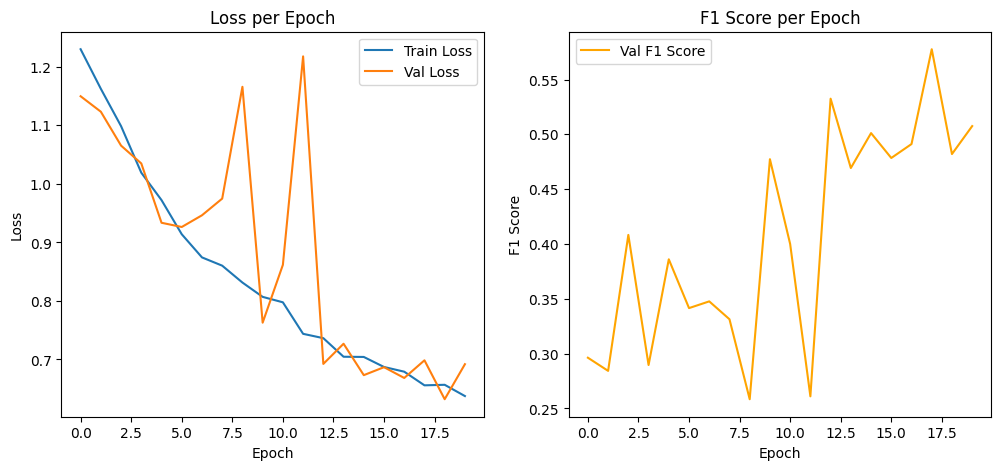

In [196]:
# Binary Cross Entropy Loss for binary classification
# instructing the loss function to treat errors in predicting class 1 as six times more significant than errors in predicting class 0.
class_weights = torch.tensor([1.0, 7.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.5,
    weight_decay=0.0001,
)
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=20,
    save_path=os.path.join(saved_models_dir, "cnn5_melgrams.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: REAL  margot-to-biden: FAKE
margot-original: FAKE    ryan-to-trump: FAKE
                         ryan-to-biden: FAKE
                        ryan-to-margot: FAKE
                          ryan-to-musk: FAKE
                        ryan-to-taylor: FAKE
                        margot-to-musk: FAKE
                         ryan-to-obama: FAKE
                       margot-to-obama: FAKE
                      margot-to-taylor: FAKE
                         ryan-to-linus: FAKE
                       margot-to-trump: FAKE
                        margot-to-ryan: FAKE
                       margot-to-linus: FAKE


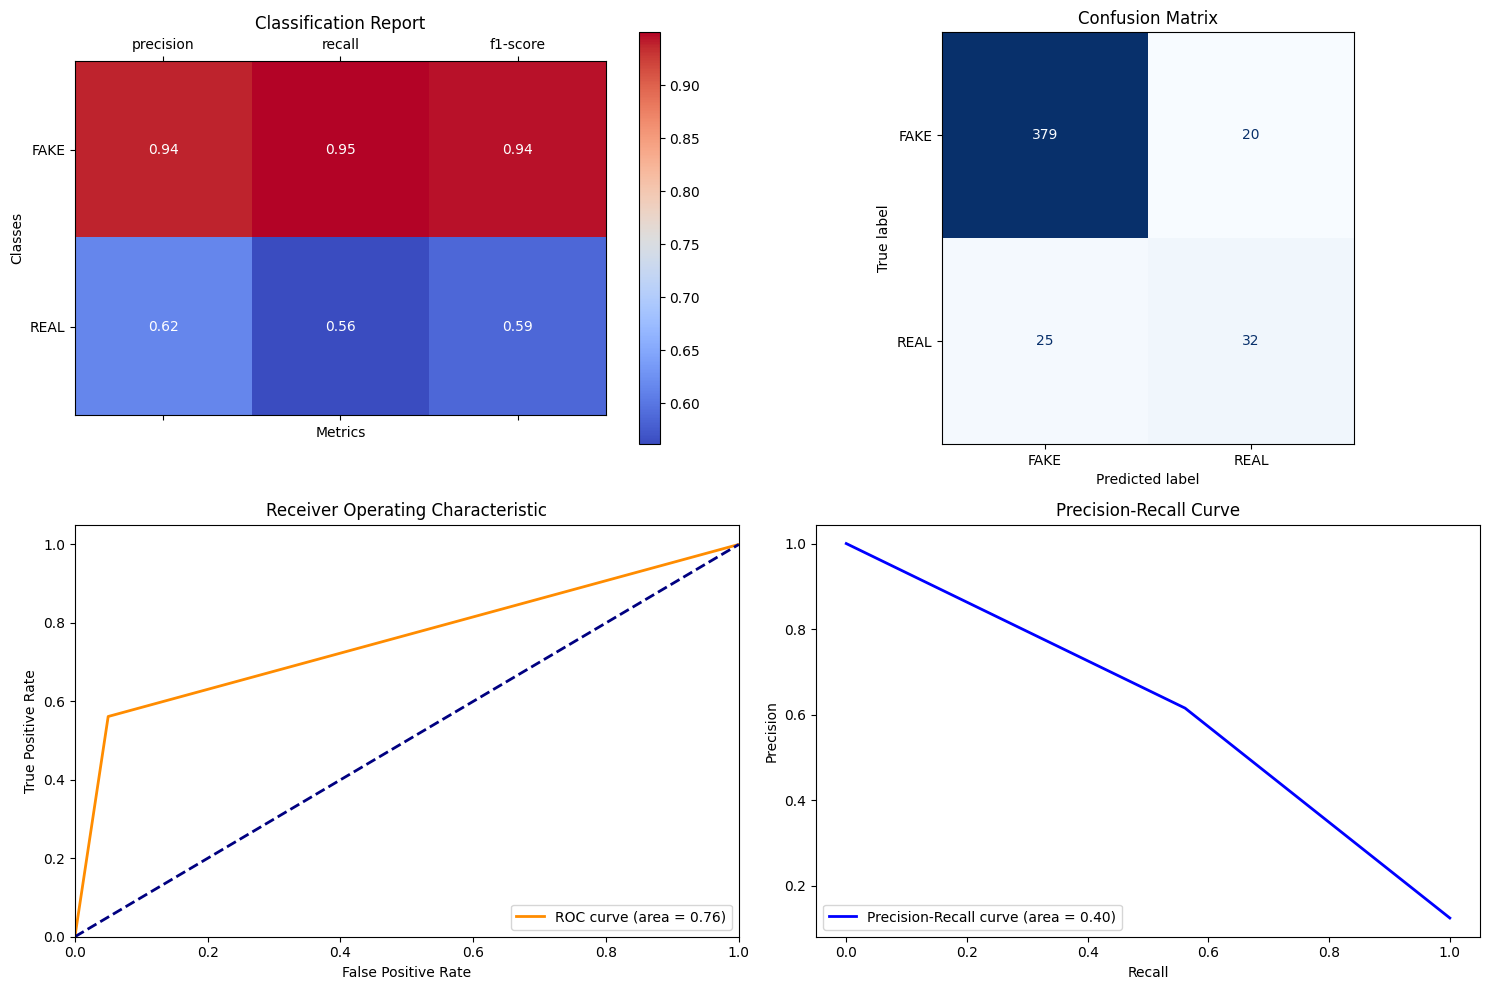

In [197]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "cnn5_melgrams.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

#### Resnet - Transfer Learning
Information about the fine tuning can be found [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [123]:
class ResNetForAudio(nn.Module):
    def __init__(self, model):
        super(ResNetForAudio, self).__init__()
        self.model = model
        self.model.conv1 = nn.Conv2d(
            1,
            64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,  # change input layer for pickle files
        )
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, 1)  # Binary classification

    def forward(self, x):
        return self.model(x)


model = ResNetForAudio(models.resnet18(weights="IMAGENET1K_V1")).to(device)
summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [125]:
class_weights = torch.tensor([1.0, 6.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0001,
    momentum=0.9,
)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Epoch 1/15, Train Loss: 0.9654, Train Acc: 0.6815, Val Loss: 0.9250, Val Acc: 0.7500, Val Precision: 0.2755, Val Recall: 0.6134, Val F1: 0.3802
Model saved at epoch 1
Epoch 2/15, Train Loss: 0.7867, Train Acc: 0.7620, Val Loss: 0.7622, Val Acc: 0.7994, Val Precision: 0.3548, Val Recall: 0.7395, Val F1: 0.4796
Model saved at epoch 2
Epoch 3/15, Train Loss: 0.6757, Train Acc: 0.7940, Val Loss: 0.6926, Val Acc: 0.8540, Val Precision: 0.4479, Val Recall: 0.7227, Val F1: 0.5531
Model saved at epoch 3
Epoch 4/15, Train Loss: 0.5906, Train Acc: 0.8152, Val Loss: 0.7540, Val Acc: 0.8183, Val Precision: 0.3784, Val Recall: 0.7059, Val F1: 0.4927
Epoch 5/15, Train Loss: 0.5158, Train Acc: 0.8392, Val Loss: 0.6097, Val Acc: 0.8487, Val Precision: 0.4384, Val Recall: 0.7479, Val F1: 0.5528
Epoch 6/15, Train Loss: 0.4775, Train Acc: 0.8550, Val Loss: 0.5642, Val Acc: 0.8130, Val Precision: 0.3927, Val Recall: 0.9076, Val F1: 0.5482
Epoch 7/15, Train Loss: 0.4136, Train Acc: 0.8671, Val Loss: 0.5577

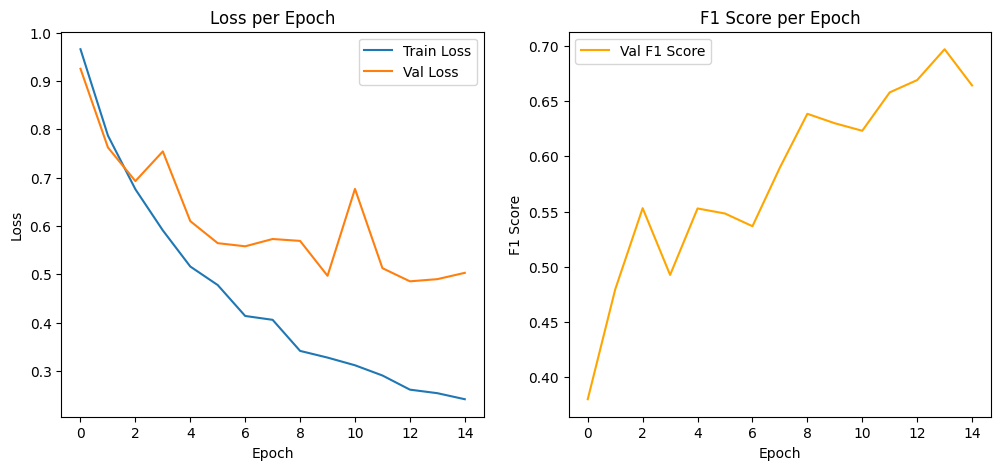

In [126]:
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=15,
    save_path=os.path.join(saved_models_dir, "pretrained_resnet.pth"),
    device=device,
)

     Original Samples      Converted Samples
margot-original: REAL    ryan-to-biden: FAKE
  ryan-original: FAKE  margot-to-linus: FAKE
                        margot-to-ryan: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-linus: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-obama: FAKE
                        margot-to-musk: FAKE
                      margot-to-taylor: FAKE
                         ryan-to-trump: FAKE
                       margot-to-obama: FAKE
                        ryan-to-margot: FAKE
                       margot-to-biden: FAKE
                       margot-to-trump: FAKE


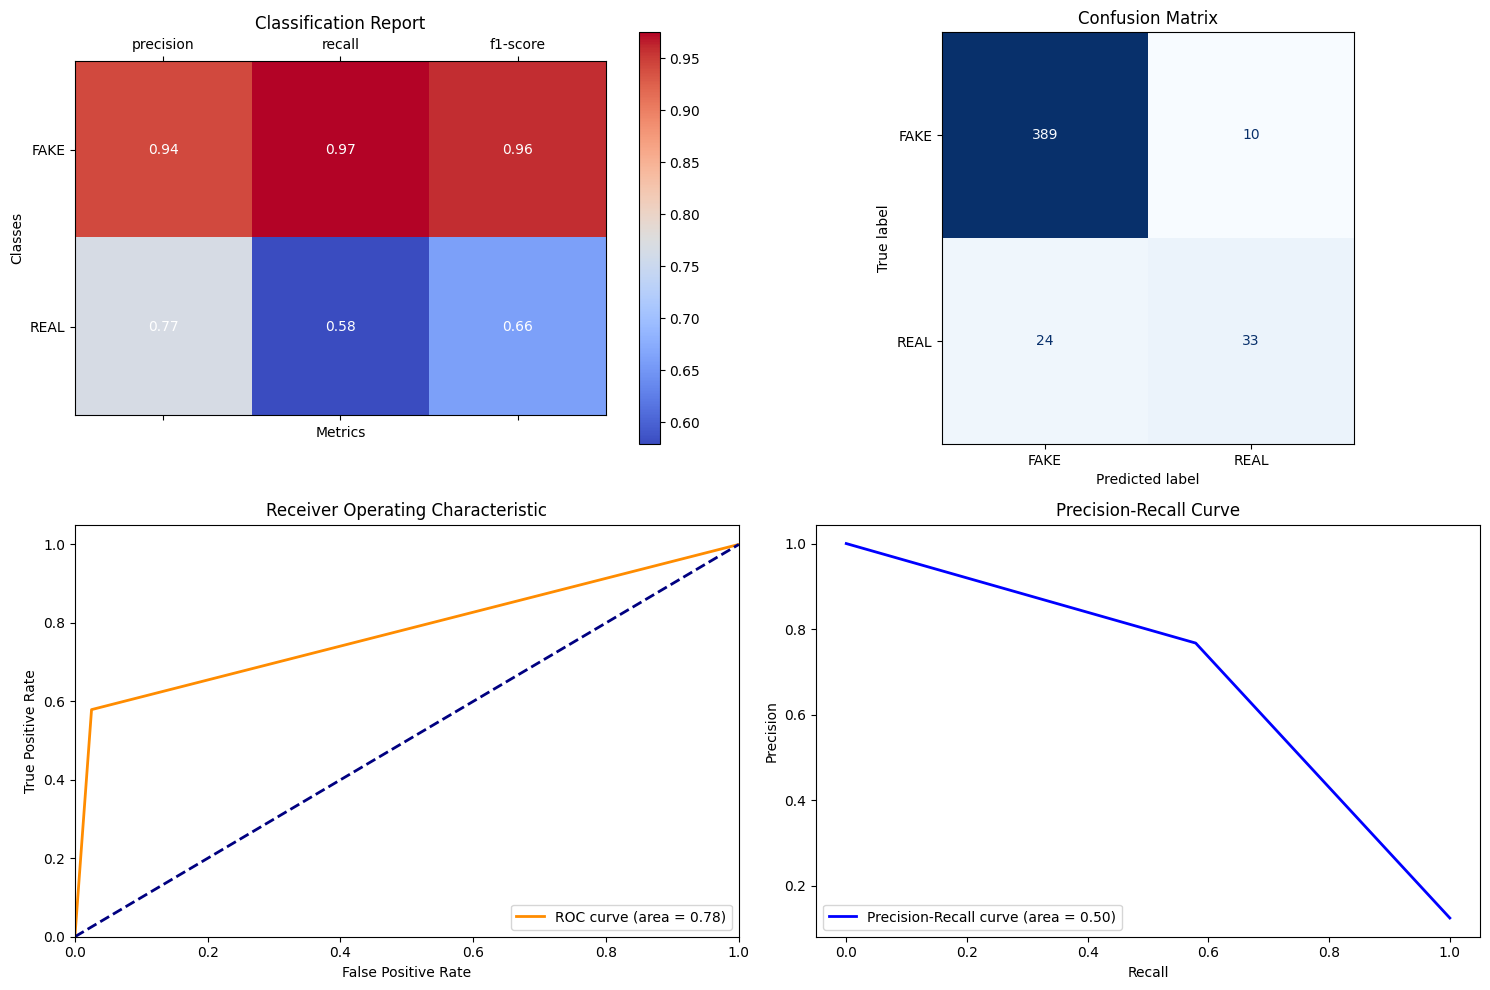

In [127]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "pretrained_resnet.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)

In [148]:
model = ResNetForAudio(models.resnet34(weights="IMAGENET1K_V1")).to(device)
summary(model, (1, 128, 128))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\AnnaKoutougera/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:21<00:00, 4.11MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [149]:
class_weights = torch.tensor([1.0, 6.0])  # Adjust weights based on imbalance
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=0.0001,
#     momentum=0.9,
# )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1/15, Train Loss: 1.1259, Train Acc: 0.6552, Val Loss: 1.2099, Val Acc: 0.5851, Val Precision: 0.1947, Val Recall: 0.7395, Val F1: 0.3082
Model saved at epoch 1
Epoch 2/15, Train Loss: 0.9721, Train Acc: 0.6137, Val Loss: 0.9486, Val Acc: 0.5924, Val Precision: 0.2144, Val Recall: 0.8487, Val F1: 0.3424
Model saved at epoch 2
Epoch 3/15, Train Loss: 0.8305, Train Acc: 0.6704, Val Loss: 0.8259, Val Acc: 0.7542, Val Precision: 0.3038, Val Recall: 0.7479, Val F1: 0.4320
Model saved at epoch 3
Epoch 4/15, Train Loss: 0.7085, Train Acc: 0.7229, Val Loss: 0.7765, Val Acc: 0.6586, Val Precision: 0.2582, Val Recall: 0.9244, Val F1: 0.4037
Epoch 5/15, Train Loss: 0.6620, Train Acc: 0.7299, Val Loss: 0.6028, Val Acc: 0.7731, Val Precision: 0.3420, Val Recall: 0.8824, Val F1: 0.4930
Model saved at epoch 5
Epoch 6/15, Train Loss: 0.6295, Train Acc: 0.7667, Val Loss: 0.6611, Val Acc: 0.7805, Val Precision: 0.3404, Val Recall: 0.8067, Val F1: 0.4788
Epoch 7/15, Train Loss: 0.5943, Train Acc: 0

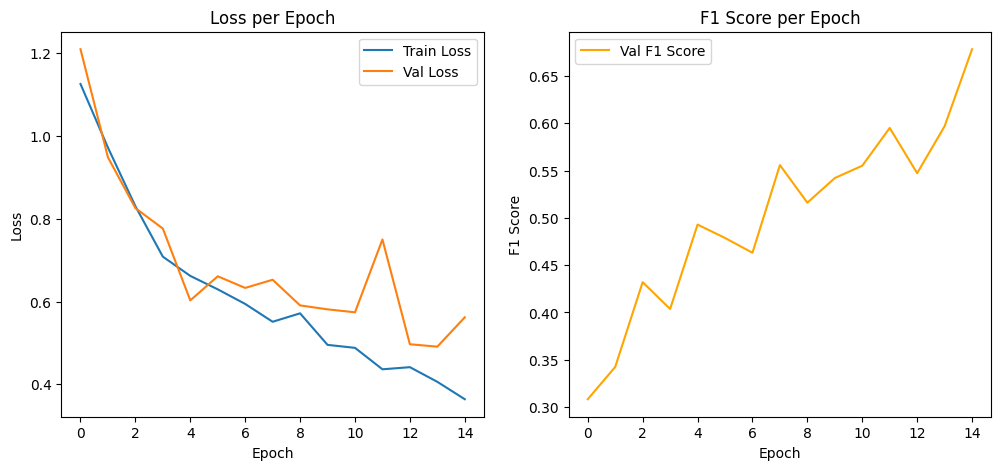

In [150]:
train.train_model(
    model,
    criterion,
    optimizer,
    train_image_dataloader,
    val_image_dataloader,
    num_epochs=15,
    save_path=os.path.join(saved_models_dir, "pretrained_resnet2.pth"),
    device=device,
)

     Original Samples      Converted Samples
  ryan-original: FAKE   margot-to-musk: FAKE
margot-original: REAL    ryan-to-obama: FAKE
                        ryan-to-taylor: FAKE
                         ryan-to-trump: FAKE
                       margot-to-biden: FAKE
                      margot-to-taylor: FAKE
                       margot-to-linus: FAKE
                        ryan-to-margot: FAKE
                          ryan-to-musk: FAKE
                         ryan-to-linus: FAKE
                         ryan-to-biden: FAKE
                       margot-to-obama: FAKE
                        margot-to-ryan: FAKE
                       margot-to-trump: FAKE


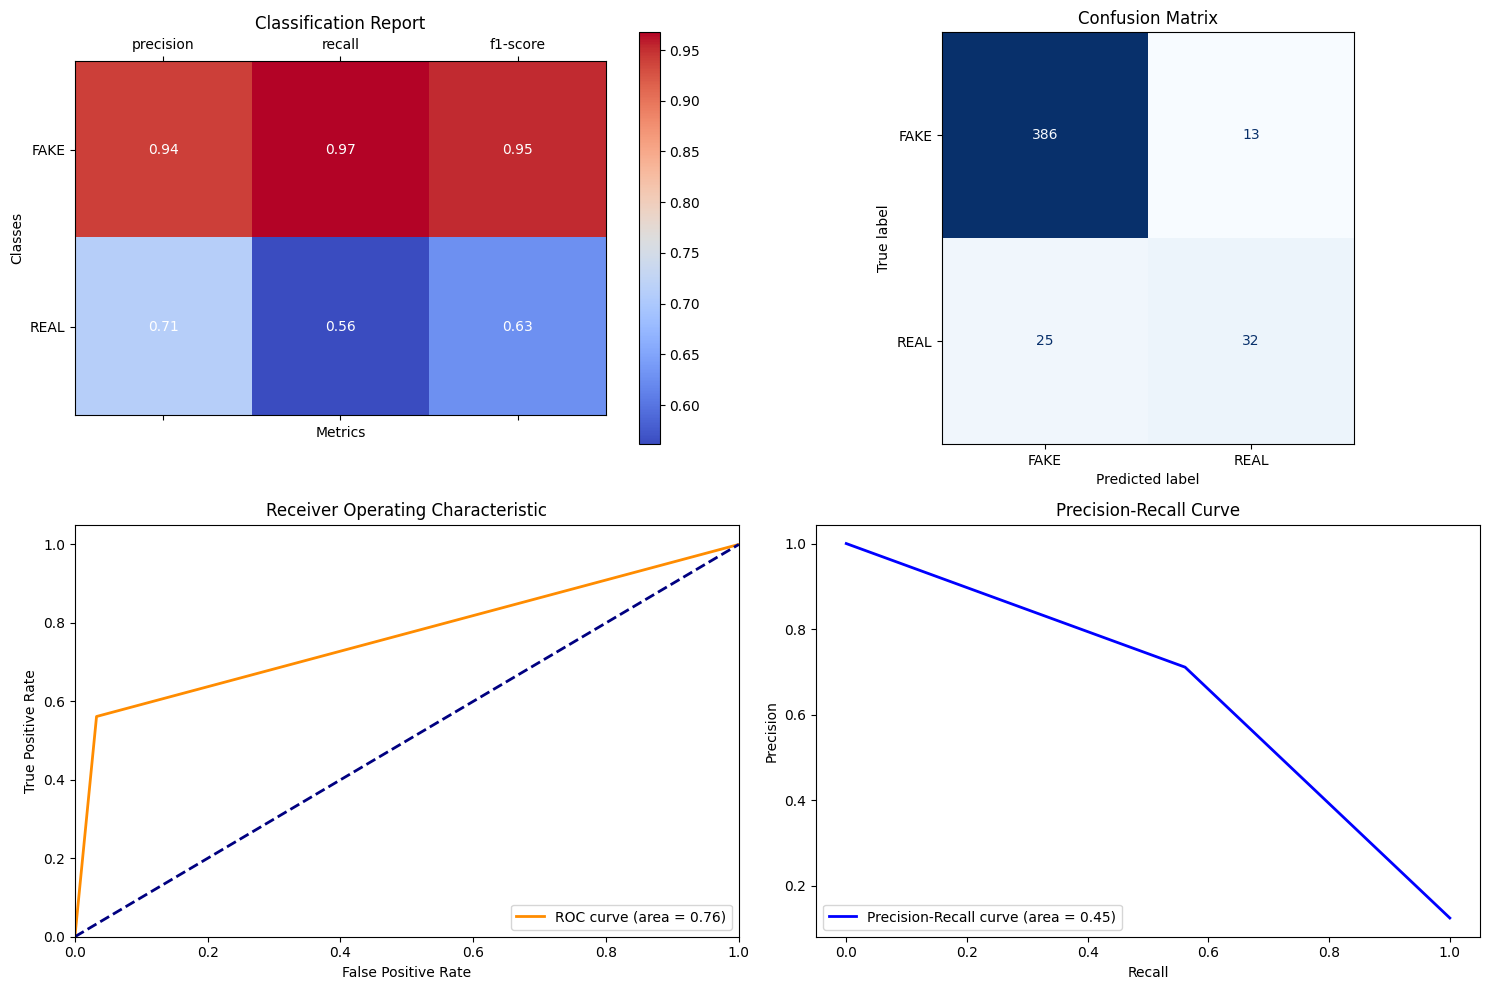

In [151]:
# Load the best model and evaluate on the test set
checkpoint = torch.load(os.path.join(saved_models_dir, "pretrained_resnet2.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.eval()
prediction_plotting.generate_report(model, test_image_dataloader, device)